We want to show the Electric, Magnetic, and Pixel Intensity from Swarm B

In [2]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp

import scienceplots

plt.style.use(['science','no-latex'])
alt=90

Load IGRF coefficients ...


In [3]:
time_array=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6))

In [4]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[1], **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [5]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [6]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [7]:
#Lets do B first
ds = requester( 
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
BNEC=ds["B_NEC_res_CHAOS"]
Btime = BNEC.index.to_numpy()
BNEC = arrangement(Btime, ds["B_NEC_res_CHAOS"], 3)




                                   Radius  \
Timestamp                                   
2022-12-19 14:04:00.010546923  6872238.82   
2022-12-19 14:04:00.030546904  6872238.96   
2022-12-19 14:04:00.050546885  6872239.10   
2022-12-19 14:04:00.070546865  6872239.25   
2022-12-19 14:04:00.090546846  6872239.39   
...                                   ...   
2022-12-19 14:05:59.902414083  6873210.19   
2022-12-19 14:05:59.922414064  6873210.37   
2022-12-19 14:05:59.942414045  6873210.54   
2022-12-19 14:05:59.962414026  6873210.72   
2022-12-19 14:05:59.982414007  6873210.90   

                                                                 B_NEC_res_CHAOS  \
Timestamp                                                                          
2022-12-19 14:04:00.010546923  [82.78851767348624, -138.16134622453387, 36.38...   
2022-12-19 14:04:00.030546904  [82.75096559278973, -138.28340700805347, 36.37...   
2022-12-19 14:04:00.050546885  [82.6129967472325, -138.48937014403464, 36.388.

C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\2246279540.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  barranged[j][k] = array[j][k]


In [8]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_inverse_scipy(q):
    # Ensure q is a numpy array
    q = np.asarray(q)
    
    # Create a Rotation object from the quaternion
    rotation = R.from_quat(q)  # Note: scipy uses [x, y, z, w] format
    
    # Compute the inverse rotation
    inverse_rotation = rotation.inv()
    
    
    return inverse_rotation

In [9]:

def find_closest_indices(times1, times2):
    # Convert to numpy arrays
    times1 = np.array(times1)
    times2 = np.array(times2)
    
    # Compute the differences between each time in times1 and all times in times2
    # Resulting in a 2D array where each row contains the absolute differences for one time in times1
    differences = np.abs(times1[:, None] - times2)
    
    # Find the index of the minimum difference for each time in times1
    closest_indices = np.argmin(differences, axis=1)
    
    return closest_indices

In [10]:
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import geopack.geopack as gp
def footprint(time, latitude, longitude, altitude, alt,vsw= [-400,0,0]):
    """
    time, datetime, time for magnetic data for footprint
    vsw velocity of solar wind, tuple of x,y,z
    longitude of satellite in degrees
    latitude of satellite in degrees
    altitude of satellite in km from centre of earth (should be above ~6371)
    THIS CODE ONLY Works in the NOrthern hemisphere

    """
    def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
    def x(t, params_x):
        return cubic(t, *params_x)

    def y(t, params_y):
        return cubic(t, *params_y)

    def z(t, params_z):
        return cubic(t, *params_z)
    def radius(t, params_x, params_y, params_z):
        return np.sqrt(x(t, params_x)**2 + y(t, params_y)**2 + z(t, params_z)**2)
    
    def curve_fit_func(xx,yy,zz, differencealt):
        
        r = np.linspace(1, 1.5, 100000)# construct an array of radiuses from 1-1.5

        radius_data=np.sqrt(xx**2+yy**2+zz**2)

        params_x, _ = curve_fit(cubic, radius_data, xx) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy)
        params_z, _ = curve_fit(cubic, radius_data, zz)

        

        index_closest=np.argmin(np.abs(radius(r, params_x, params_y, params_z)-(alt-differencealt+6371)/6371))#Find the index that produces the closest radius to the altitude

        return x(r[index_closest],params_x ),y(r[index_closest],params_y ),z(r[index_closest],params_z )
    
    t1 = time
    t0 = datetime(1970,1,1) #epoch
    ut = (t1-t0).total_seconds()
    lat_sat=np.deg2rad(latitude)
    lon_sat=np.deg2rad(longitude) #converts to radii
    gp.recalc(ut)
    r, theta= gp.geodgeo(altitude,lat_sat,1) #this r accounts for earths oblateness, so we need to find the difference between my 6371 assumption and the real value and account for that
    differencearray= (altitude+6371)-r
    x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
    

    x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

    x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array
    for index in range(len(x_gsm)):
        x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=1.6, maxloop=3000 ) #traces each set of lat,lon,alt outward
        _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, maxloop=1000 )#Traces inward

        x_foot[index],y_foot[index],z_foot[index] = curve_fit_func(xx2,yy2,zz2, differencearray[index])


            

    x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

    alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
    for index in range(len(x_done)):
        
        r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

        alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

    print(alt_sat_done, 'altitude derived from fit')

    if np.any(np.abs(alt_sat_done - alt) > 5):
        raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
    print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
    sat_lla=np.array([ np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360,  alt_sat_done])
    return sat_lla

In [11]:
measurements_E = [
        "VsatN",
        "VsatE",
        "VsatC",
        "Evx",
        "Evy",
        "Evz",
        "Vixv",
        "Viy",
        "Viz",
        "Quality_flags",
    ]
ds = requester( 
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
dsB = requester( 
    'SW_OPER_MAGB_HR_1B', #Mag B, high resolution, 50Hz B (Magnetic field)
    ["q_NEC_CRF"], #Magnetic field in NEC coordinates
    False, 
    asynchronous=False,
    show_progress=False)

latitude, longitude, altitude = dsB['Latitude'].to_numpy(), dsB['Longitude'].to_numpy(),  (dsB["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data


                                  Radius        Evy       Evz   Latitude  \
Timestamp                                                                  
2022-12-19 14:04:00.006750107  6872232.0 -43.889839  8.471214  65.467339   
2022-12-19 14:04:00.068749905  6872232.5 -44.201260  8.235891  65.463417   
2022-12-19 14:04:00.131750107  6872233.0 -50.670647  8.086688  65.459442   
2022-12-19 14:04:00.193749905  6872233.5 -45.661617  8.649044  65.455521   
2022-12-19 14:04:00.256750107  6872233.5 -47.468952  9.233665  65.451538   
...                                  ...        ...       ...        ...   
2022-12-19 14:05:59.693749905  6873200.0 -17.630184 -1.469386  57.895660   
2022-12-19 14:05:59.756750107  6873200.5 -18.456339 -1.843340  57.891670   
2022-12-19 14:05:59.818749905  6873201.0 -17.988640 -2.056162  57.887745   
2022-12-19 14:05:59.881750107  6873201.5 -19.799648 -2.261700  57.883759   
2022-12-19 14:05:59.943749905  6873202.0 -18.056873 -1.519680  57.879833   

           

In [12]:
sat_lla_B=footprint(time_array[0], latitude, longitude, altitude, alt, vsw=[-345,12,-12])


[90.14225425 90.14191213 90.14156972 ... 90.2436815  90.24327632
 90.24287033] altitude derived from fit
[-117.78802656 -117.78781435 -117.78760225 ... -116.90968465 -116.90958766
 -116.90949058] [65.91364159 65.91241737 65.91119316 ... 58.59280499 58.591589
 58.59037301] lat and lon


In [13]:
print(sat_lla_B)

[[  65.91364159   65.91241737   65.91119316 ...   58.59280499
    58.591589     58.59037301]
 [-117.78802656 -117.78781435 -117.78760225 ... -116.90968465
  -116.90958766 -116.90949058]
 [  90.14225425   90.14191213   90.14156972 ...   90.2436815
    90.24327632   90.24287033]]


In [14]:
indicies=find_closest_indices(ds.index, dsB.index)
quatnecrf=dsB["q_NEC_CRF"].to_numpy()[indicies]
quaternions = []
Esat=np.array([ds["Evx"] , ds["Evy"], ds["Evz"]]).T
vsat=np.array([ds["Vixv"] , ds["Viy"], ds["Viz"]]).T
Etime = ds.index
ENEC=[]
VNEC=[]
for i in range(len(quatnecrf)):
    inverse_quat = quaternion_inverse_scipy(dsB["q_NEC_CRF"].to_numpy()[indicies][i])
    rot_NEC_V= inverse_quat.apply(Esat[i])
    ENEC.append(rot_NEC_V)

    rot_NEC_V= inverse_quat.apply(vsat[i])
    VNEC.append(rot_NEC_V)

ENEC=np.array(ENEC)
VNEC=np.array(VNEC)


Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [15]:
from scipy.interpolate import CubicSpline
cs_lat = CubicSpline( Btime, sat_lla_B[0])
cs_lon = CubicSpline( Btime, sat_lla_B[1])
cs_alt = CubicSpline( Btime, sat_lla_B[2])
print(ds['Latitude'].to_numpy())
print(latitude)
sat_lla_E= np.array([cs_lat(Etime), cs_lon(Etime),  cs_alt(Etime)]) #km  # Gets Emphermis data latitude, longitude, altitude


[65.46734  65.46342  65.45944  ... 57.887745 57.88376  57.879833]
[65.4075031 65.406239  65.4049749 ... 57.8202265 57.8189604 57.8176943]


In [16]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time_range=time_array, colors='r')


Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


In [17]:

#sat_lla_E=footprint(time_array[0],latitude_E, longitude_E, altitude_E, alt, vsw=[-345,12,-12])

conjunction_obj = asilib.Conjunction(asi, (np.array(Etime), sat_lla_E.T))

In [18]:
#Now lets 

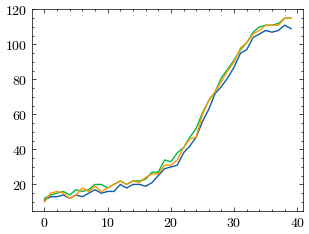

In [19]:
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity()
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
plt.plot(area_intensity) #This gives us a resolution of 3Hz.


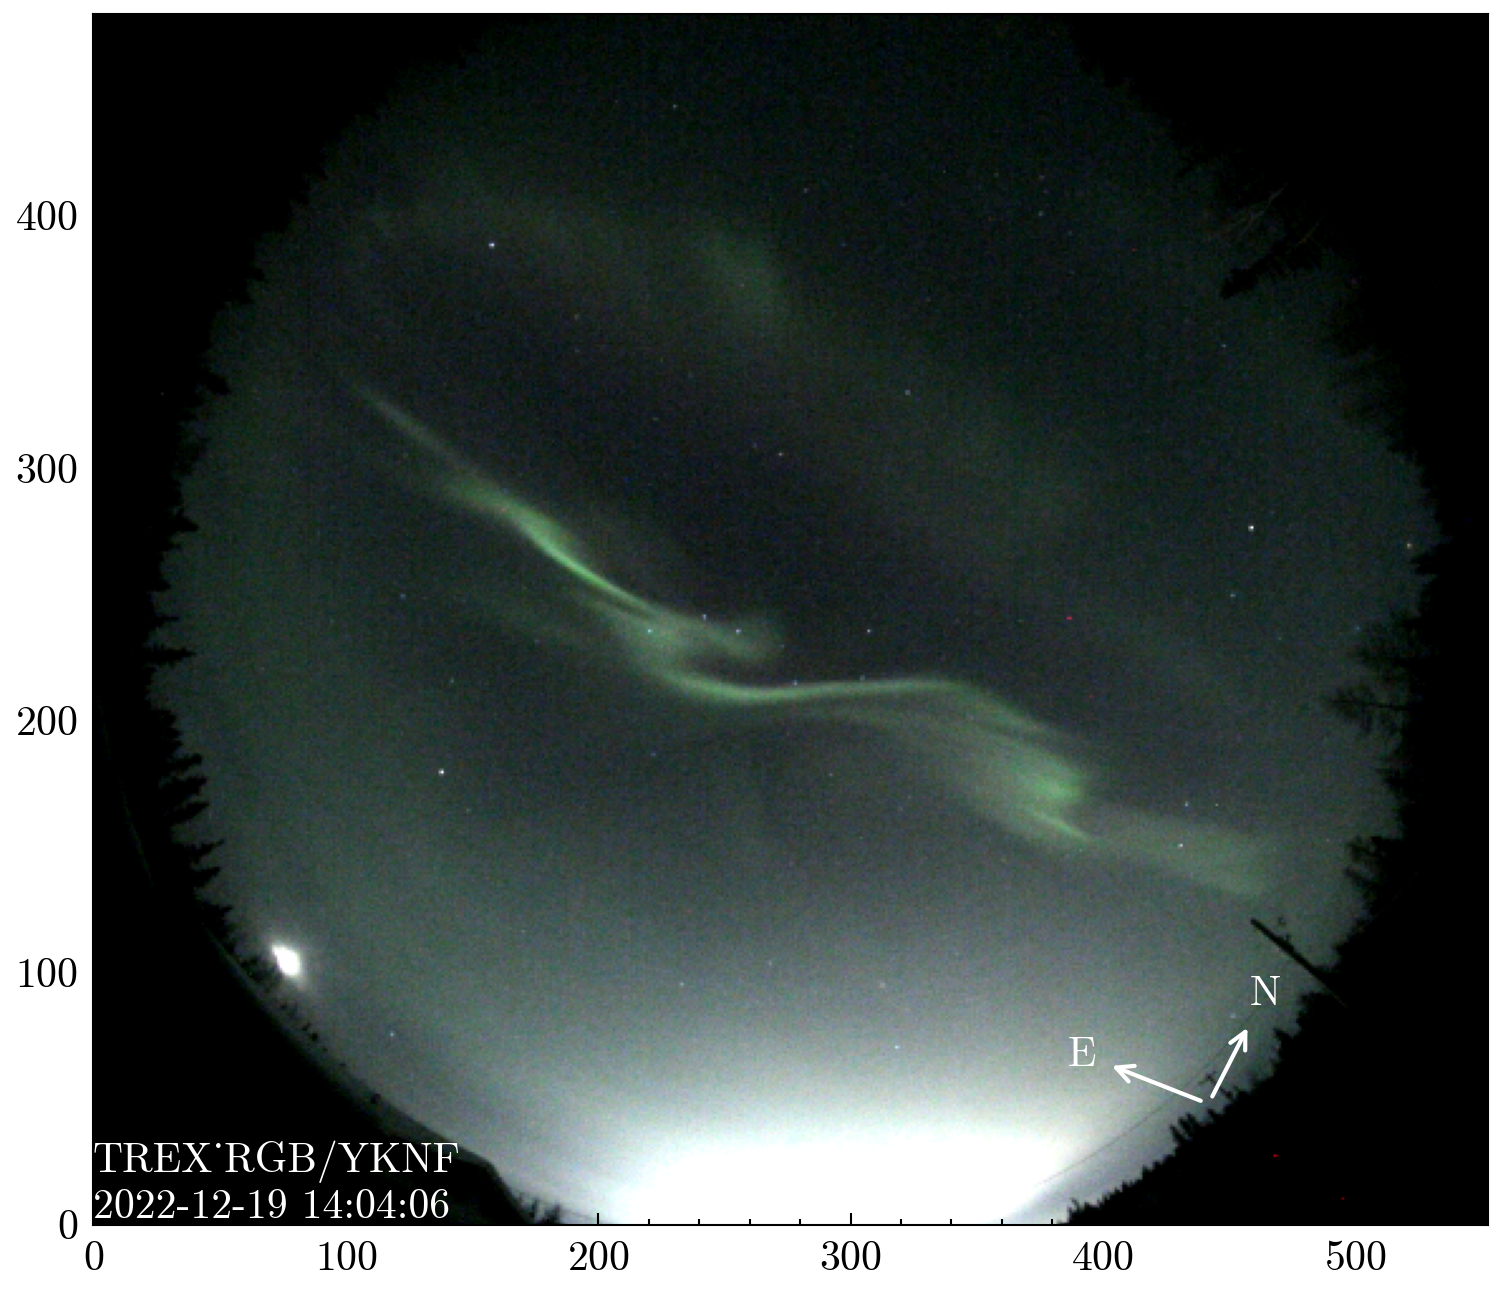

In [20]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=datetime(2022,12,19,14,4,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


[[-117.20056  -117.20056  -117.20056  ... -117.20056  -117.20056
  -117.20056 ]
 [-117.20056  -117.20056  -117.20056  ... -118.211975 -118.211975
  -118.211975]
 [-116.91376  -116.91376  -116.91376  ... -118.47168  -118.47168
  -118.47168 ]
 ...
 [-108.70166  -108.70166  -108.70166  ... -112.75531  -112.75531
  -112.75531 ]
 [-108.81473  -108.81473  -108.81473  ... -112.60504  -112.60504
  -112.60504 ]
 [-108.59131  -108.59131  -108.59131  ... -108.59131  -108.59131
  -108.59131 ]]


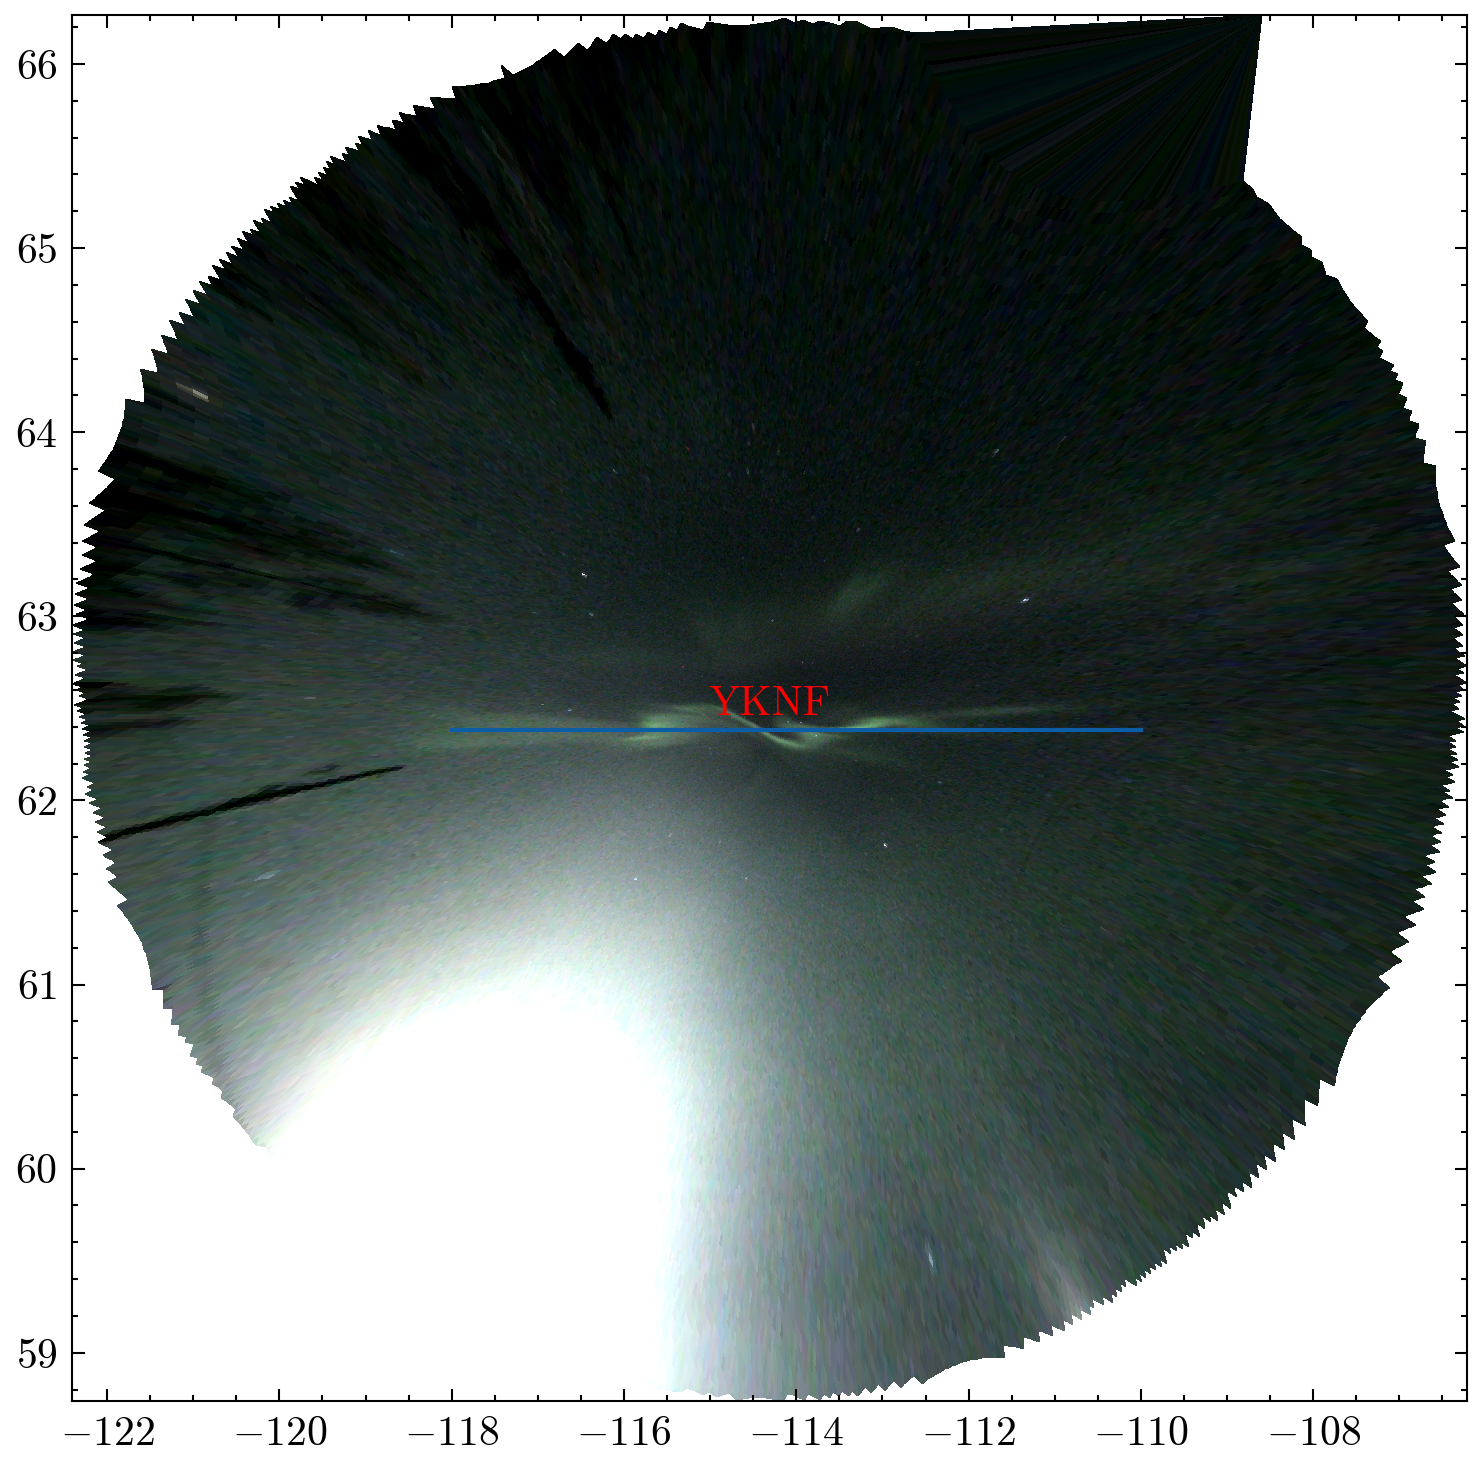

In [21]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
print(x_coords)
x = np.linspace(-118, -110, 200)
y= np.linspace(62.38, 62.38, 200)
plt.plot(x,y)


In [22]:

R=6371.0+alt
# Convert degrees to radians
def deg2rad(deg):
    return deg * np.pi / 180.0

# Haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    closest_indices = []
    for lat, lon in zip(line_lats, line_lons):
        # Calculate the distance from the current line point to all grid points
        distances = haversine(grid_lats, grid_lons, lat, lon)
        
        # Find the index of the minimum distance
        min_index = np.unravel_index(np.argmin(distances), distances.shape)
        closest_indices.append(min_index)
    
    return closest_indices

# Example usage
grid_lats = y_coords
grid_lons = x_coords

line_lats = y
line_lons = x

closest_indices = np.transpose(find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons))
print(np.shape(closest_indices))


(2, 200)


In [23]:
print(closest_indices)
print(np.shape(grid_lons))
print(np.shape(grid_lats))

[[141 142 142 142 142 143 143 143 143 143 143 143 144 144 144 145 145 145
  145 146 146 146 147 146 147 147 148 148 149 149 149 150 150 151 151 151
  152 152 153 153 154 155 155 156 156 157 157 158 159 160 160 161 162 163
  164 164 165 166 167 168 169 170 171 172 173 174 176 177 178 179 181 182
  183 185 186 187 189 190 192 193 195 197 198 200 202 203 205 207 209 211
  212 214 216 218 220 222 223 225 227 229 231 233 235 236 238 240 242 244
  245 247 249 251 252 254 256 257 259 260 262 263 265 266 268 269 271 272
  273 275 276 277 278 280 281 282 283 284 285 286 287 289 289 291 291 293
  293 294 295 296 297 298 298 299 300 301 302 303 303 304 305 305 306 307
  308 309 309 310 310 311 311 312 313 313 314 314 315 316 316 317 317 317
  319 319 319 320 320 321 321 321 322 322 323 323 324 324 325 325 326 325
  326 326]
 [460 460 459 458 457 457 456 455 454 453 452 451 451 450 449 448 447 446
  445 444 443 442 441 439 438 437 436 435 434 432 431 430 428 427 426 424
  423 421 420 418 417 415 4

In [24]:
print(grid_lons[closest_indices[0], closest_indices[1] ])

[-117.992584 -117.96661  -117.9187   -117.87189  -117.82611  -117.802
 -117.75763  -117.71423  -117.67172  -117.6301   -117.589355 -117.54941
 -117.528076 -117.48926  -117.45123  -117.39398  -117.35773  -117.32214
 -117.28723  -117.23447  -117.20111  -117.168335 -117.11868  -117.073395
 -117.02612  -116.99628  -116.95093  -116.9223   -116.87872  -116.8241
 -116.797424 -116.75668  -116.70566  -116.66696  -116.64252  -116.59473
 -116.55835  -116.51279  -116.47809  -116.43457  -116.40137  -116.34827
 -116.30792  -116.2771   -116.2384   -116.190094 -116.15335  -116.10739
 -116.06265  -116.03595  -115.98584  -115.94418  -115.9035   -115.86383
 -115.82501  -115.79535  -115.74371  -115.70752  -115.67206  -115.62396
 -115.59012  -115.54413  -115.51178  -115.46771  -115.42468  -115.38263
 -115.34656  -115.30615  -115.26654  -115.22766  -115.183655 -115.1463
 -115.10956  -115.06787  -115.02237  -114.98749  -114.947815 -114.90436
 -114.865906 -114.82364  -114.786194 -114.74011  -114.70828  -114.6

In [25]:
print(grid_lats[closest_indices[0], closest_indices[1] ])

[62.37715  62.38551  62.383568 62.38163  62.3797   62.387756 62.38577
 62.383793 62.38182  62.37986  62.377907 62.37596  62.38358  62.381588
 62.379604 62.38502  62.383007 62.38101  62.379017 62.384167 62.382153
 62.38015  62.385094 62.3742   62.37906  62.377068 62.38178  62.37977
 62.384342 62.380314 62.378315 62.38272  62.37871  62.38298  62.380974
 62.376987 62.381115 62.377136 62.381153 62.37718  62.381092 62.38293
 62.37896  62.382694 62.378735 62.380405 62.376472 62.378067 62.379597
 62.38303  62.37715  62.378555 62.379906 62.381203 62.382446 62.37856
 62.377823 62.378975 62.380085 62.379223 62.380253 62.379322 62.38028
 62.379284 62.378254 62.3772   62.38266  62.381516 62.380344 62.37915
 62.382423 62.381157 62.379864 62.38295  62.37968  62.3783   62.381218
 62.377857 62.380665 62.37724  62.37994  62.380653 62.379047 62.379658
 62.380203 62.3785   62.37895  62.379337 62.381645 62.38193  62.378063
 62.378242 62.380383 62.38046  62.38048  62.382504 62.37834  62.37821
 62.38012  62

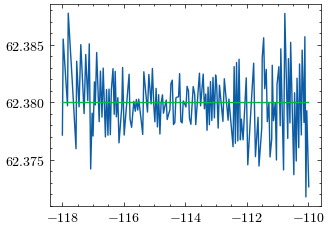

In [26]:
#plt.plot(line_lons, line_lats)
plt.plot(grid_lons[closest_indices[0], closest_indices[1] ],grid_lats[closest_indices[0], closest_indices[1] ] )
plt.plot( line_lons, line_lats)

Downloaded 20221219_1404_yknf_rgb-08_full.h5.
Downloaded 20221219_1405_yknf_rgb-08_full.h5.
Downloaded rgb_skymap_yknf_20220913-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20230114-%2B_v01.sav.



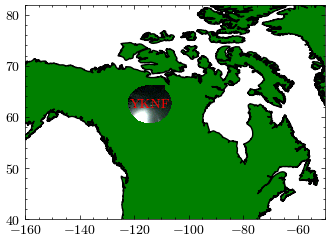

In [36]:

x_1 = np.linspace(-119, -107, 800)
y_1= np.linspace(62.36, 62.36, 800)

x_2 = np.linspace(-114, -114, 800)
y_2= np.linspace(59, 66, 800)

asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time_range=(time_array[0], time_array[-1]), redownload=True)

pixel_closest_sat = []
pixel_closest_sat_track = []
pixel_closest_1 = []
pixel_closest_2 =[]
time_ewo = []
times= []
lats = []
lons = []

movie_generator = asi.animate_map_gen()


for i, (time, image, _, im) in enumerate(movie_generator):

    indices = np.where((Etime >= np.datetime64(time)) & (Etime <= np.datetime64((time +timedelta(seconds=3)))))[0]
    coords=im.get_coordinates()
    grid_lons=coords[:,:,0]
    grid_lats=coords[:,:,1]


    closest_indices = np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0][indices], sat_lla_E[1][indices]))
    for j in range(len(closest_indices[0])):
        pixel_closest_sat.append(image[closest_indices[0][j], closest_indices[1][j] , 1])
        times.append(Etime.to_numpy()[indices[j]])
        lats.append(sat_lla_E[0][indices[j]])
        lons.append( sat_lla_E[1][indices[j]])

    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_1, x_1))
    temp_1=[]
    for j in range(len(closest_indices[0])):
        temp_1.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_1.append(temp_1)


    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_2, x_2))
    temp_2=[]
    for j in range(len(closest_indices[0])):
        temp_2.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_2.append(temp_2)
    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0], sat_lla_E[1]))
    temp_3=[]
    for j in range(len(closest_indices[0])):
        temp_3.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_sat_track.append(temp_3)
    time_ewo.append(time)

    if i==39:
        break #due to run error TODO


[Timestamp('2022-12-19 14:05:00'), Timestamp('2022-12-19 14:05:00.303030303'), Timestamp('2022-12-19 14:05:00.606060606'), Timestamp('2022-12-19 14:05:00.909090909'), Timestamp('2022-12-19 14:05:01.212121212'), Timestamp('2022-12-19 14:05:01.515151515'), Timestamp('2022-12-19 14:05:01.818181818'), Timestamp('2022-12-19 14:05:02.121212121'), Timestamp('2022-12-19 14:05:02.424242424'), Timestamp('2022-12-19 14:05:02.727272727'), Timestamp('2022-12-19 14:05:03.030303030'), Timestamp('2022-12-19 14:05:03.333333333'), Timestamp('2022-12-19 14:05:03.636363636'), Timestamp('2022-12-19 14:05:03.939393939'), Timestamp('2022-12-19 14:05:04.242424242'), Timestamp('2022-12-19 14:05:04.545454545'), Timestamp('2022-12-19 14:05:04.848484848'), Timestamp('2022-12-19 14:05:05.151515151'), Timestamp('2022-12-19 14:05:05.454545454'), Timestamp('2022-12-19 14:05:05.757575757'), Timestamp('2022-12-19 14:05:06.060606060'), Timestamp('2022-12-19 14:05:06.363636363'), Timestamp('2022-12-19 14:05:06.666666666'

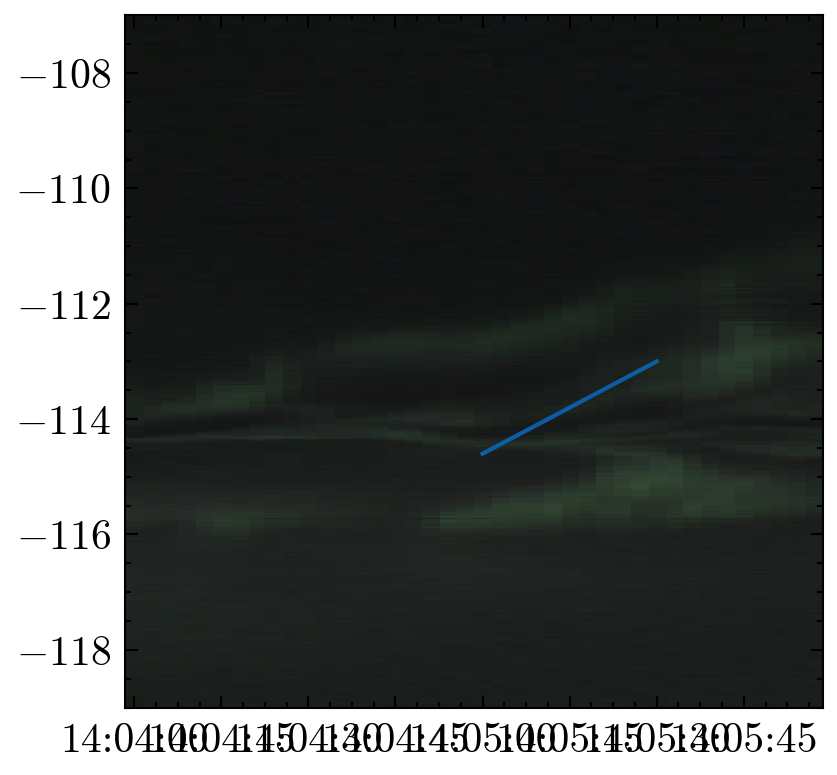

In [37]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
plt.pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_1, 1, 0 ))
import pandas as pd
y = pd.date_range(start='2022-12-19 14:05:00', end='2022-12-19 14:05:30', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-114.6,-113, 100))


[Timestamp('2022-12-19 14:05:00'), Timestamp('2022-12-19 14:05:00.454545454'), Timestamp('2022-12-19 14:05:00.909090909'), Timestamp('2022-12-19 14:05:01.363636363'), Timestamp('2022-12-19 14:05:01.818181818'), Timestamp('2022-12-19 14:05:02.272727272'), Timestamp('2022-12-19 14:05:02.727272727'), Timestamp('2022-12-19 14:05:03.181818181'), Timestamp('2022-12-19 14:05:03.636363636'), Timestamp('2022-12-19 14:05:04.090909090'), Timestamp('2022-12-19 14:05:04.545454545'), Timestamp('2022-12-19 14:05:05'), Timestamp('2022-12-19 14:05:05.454545454'), Timestamp('2022-12-19 14:05:05.909090909'), Timestamp('2022-12-19 14:05:06.363636363'), Timestamp('2022-12-19 14:05:06.818181818'), Timestamp('2022-12-19 14:05:07.272727272'), Timestamp('2022-12-19 14:05:07.727272727'), Timestamp('2022-12-19 14:05:08.181818181'), Timestamp('2022-12-19 14:05:08.636363636'), Timestamp('2022-12-19 14:05:09.090909090'), Timestamp('2022-12-19 14:05:09.545454545'), Timestamp('2022-12-19 14:05:10'), Timestamp('2022-1

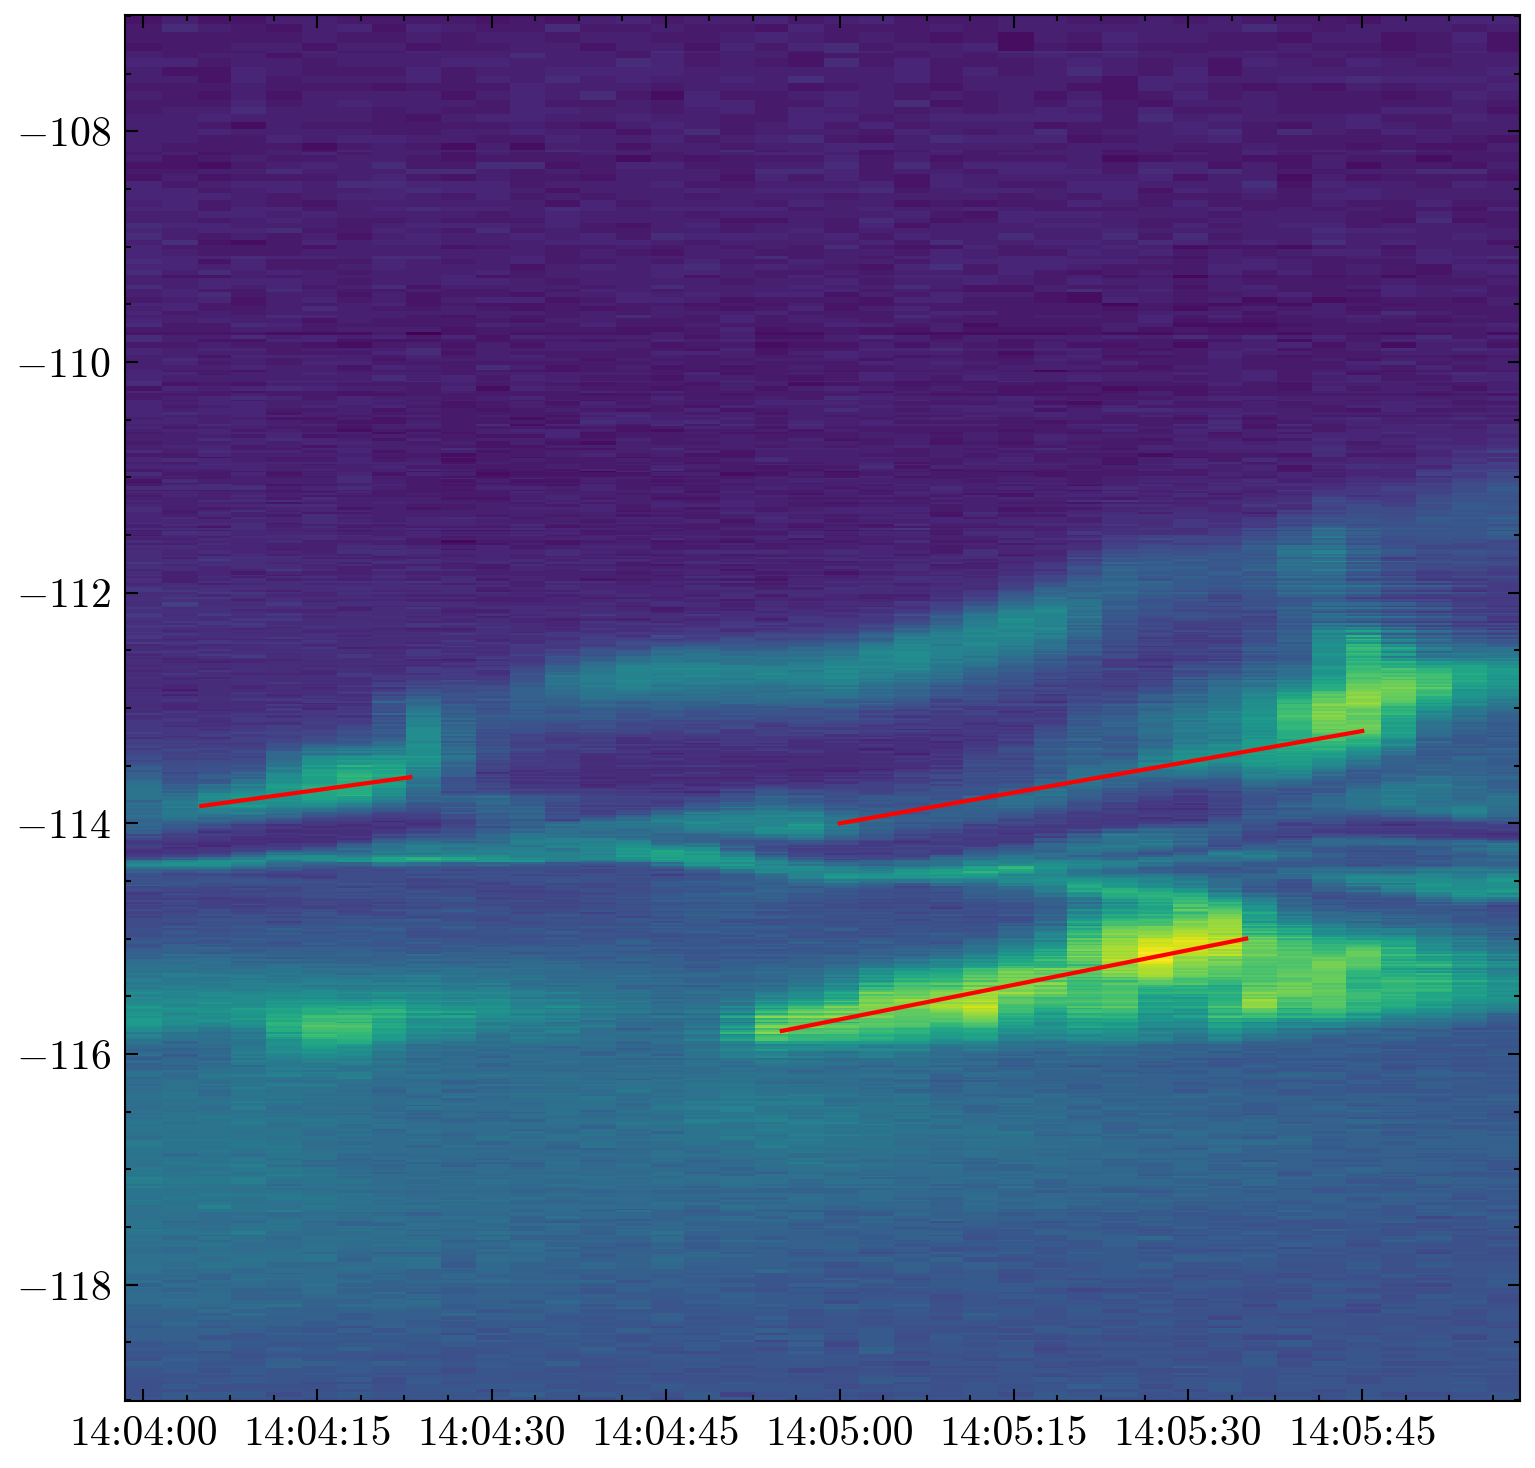

In [38]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_1, 1, 0 )[:,:,1])
#plt.contour(time_ewo, x_1,np.swapaxes(pixel_closest_1, 1, 0 )[:,:,1], 6, colors='k')
y = pd.date_range(start='2022-12-19 14:05:00', end='2022-12-19 14:05:45', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-114,-113.2, 100), color='red')
import geopy.distance
coords_1=(61.36, -114)
coords_2=(61.36, -113.2)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(45))

y = pd.date_range(start='2022-12-19 14:04:05', end='2022-12-19 14:04:23', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-113.85,-113.6, 100), color='red')
import geopy.distance
coords_1=(61.36, -113.85)
coords_2=(61.36, -113.6)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(18))

y = pd.date_range(start='2022-12-19 14:04:55', end='2022-12-19 14:05:35', periods=100).tolist()
print(y)
plt.plot(y, np.linspace(-115.8,-115, 100), color='red')
import geopy.distance
coords_1=(61.36, -115.8)
coords_2=(61.36, -115)
print(geopy.distance.geodesic(coords_1, coords_2).km)

print(geopy.distance.geodesic(coords_1, coords_2).km/(40))

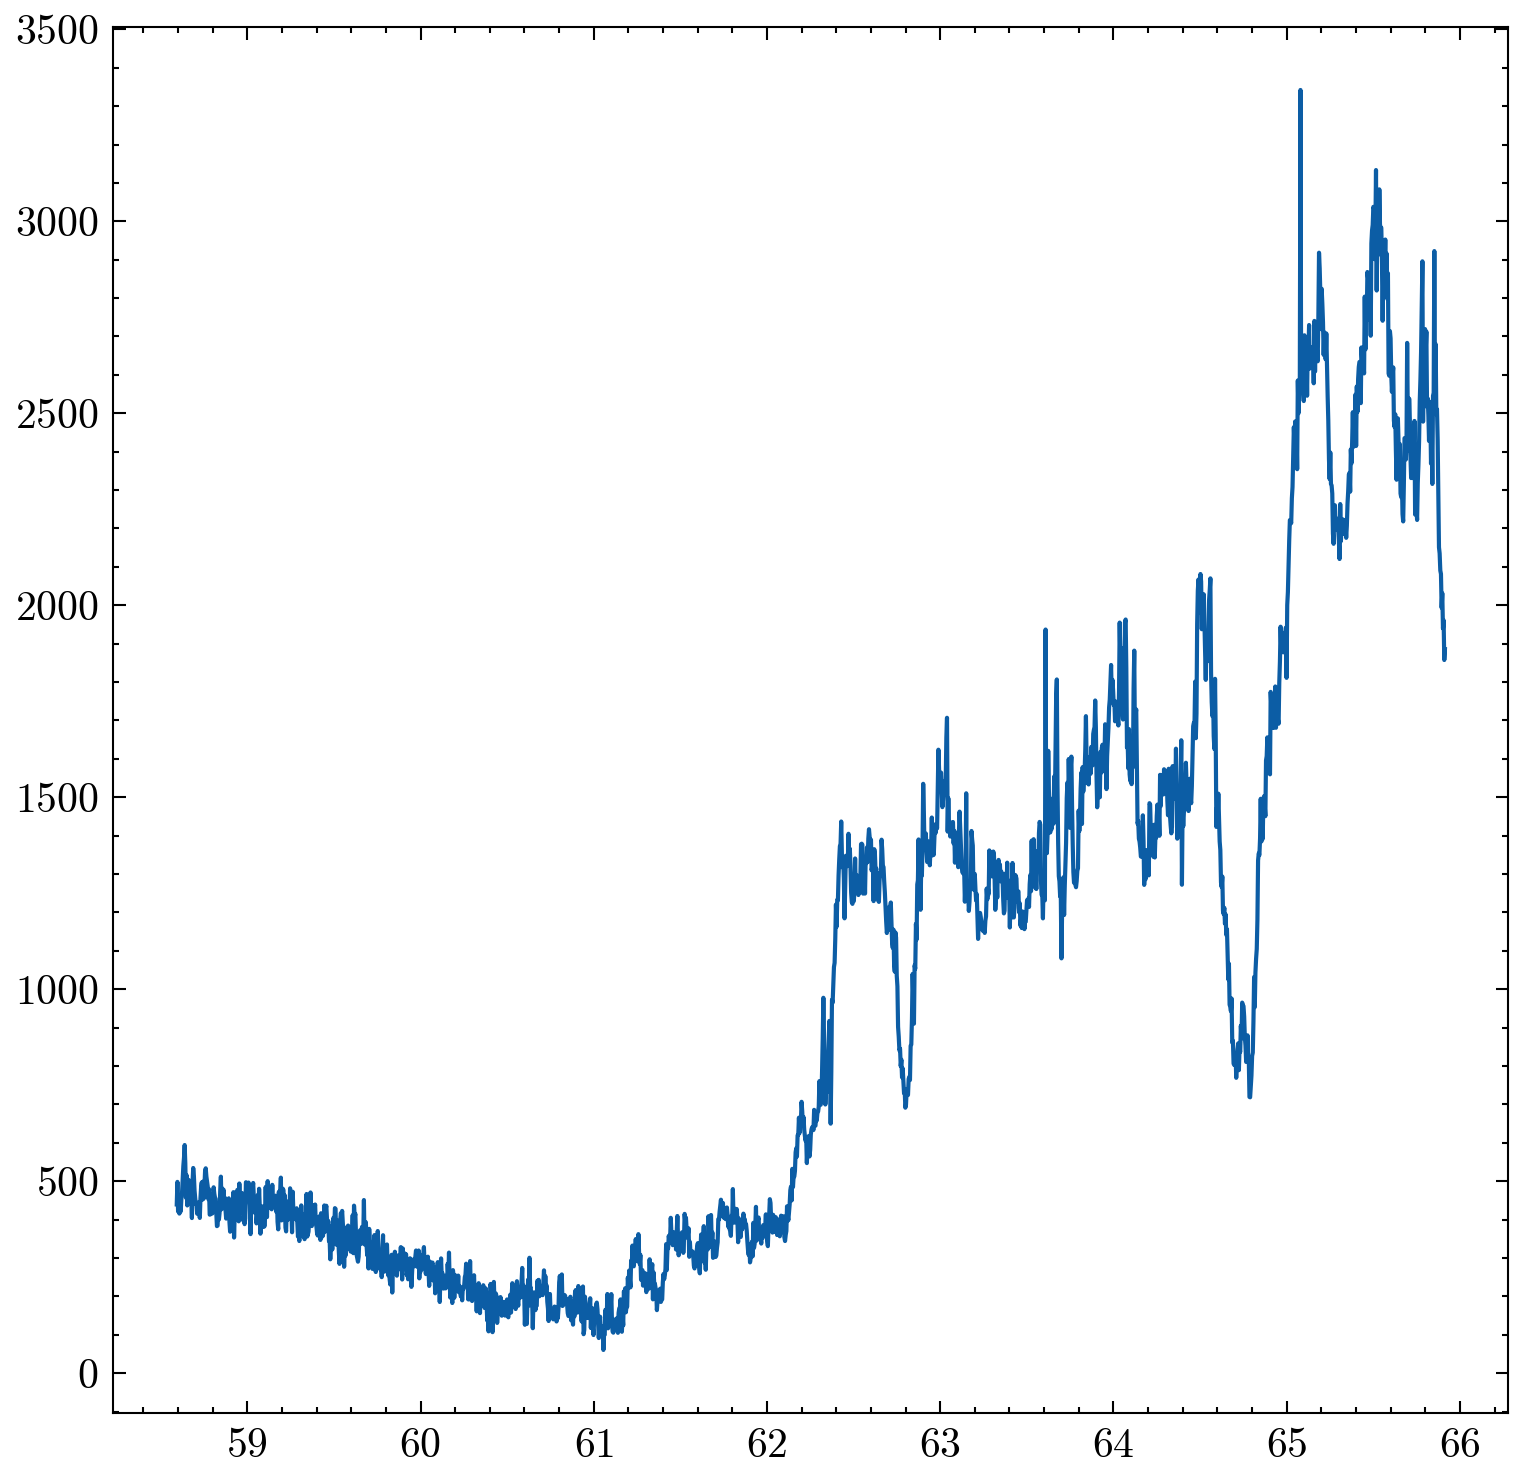

In [39]:
sat_lla_E[0]
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.plot(sat_lla_E[0], [np.sqrt(VNEC[x,0]**2+VNEC[x,1]**2+VNEC[x,2]**2) for x in range(len(VNEC))])

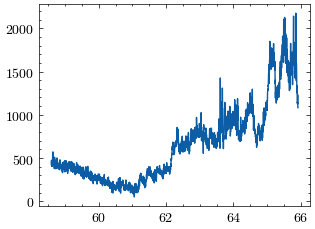

In [40]:
plt.plot(sat_lla_E[0], [np.sqrt(VNEC[x,0]**2) for x in range(len(VNEC))])

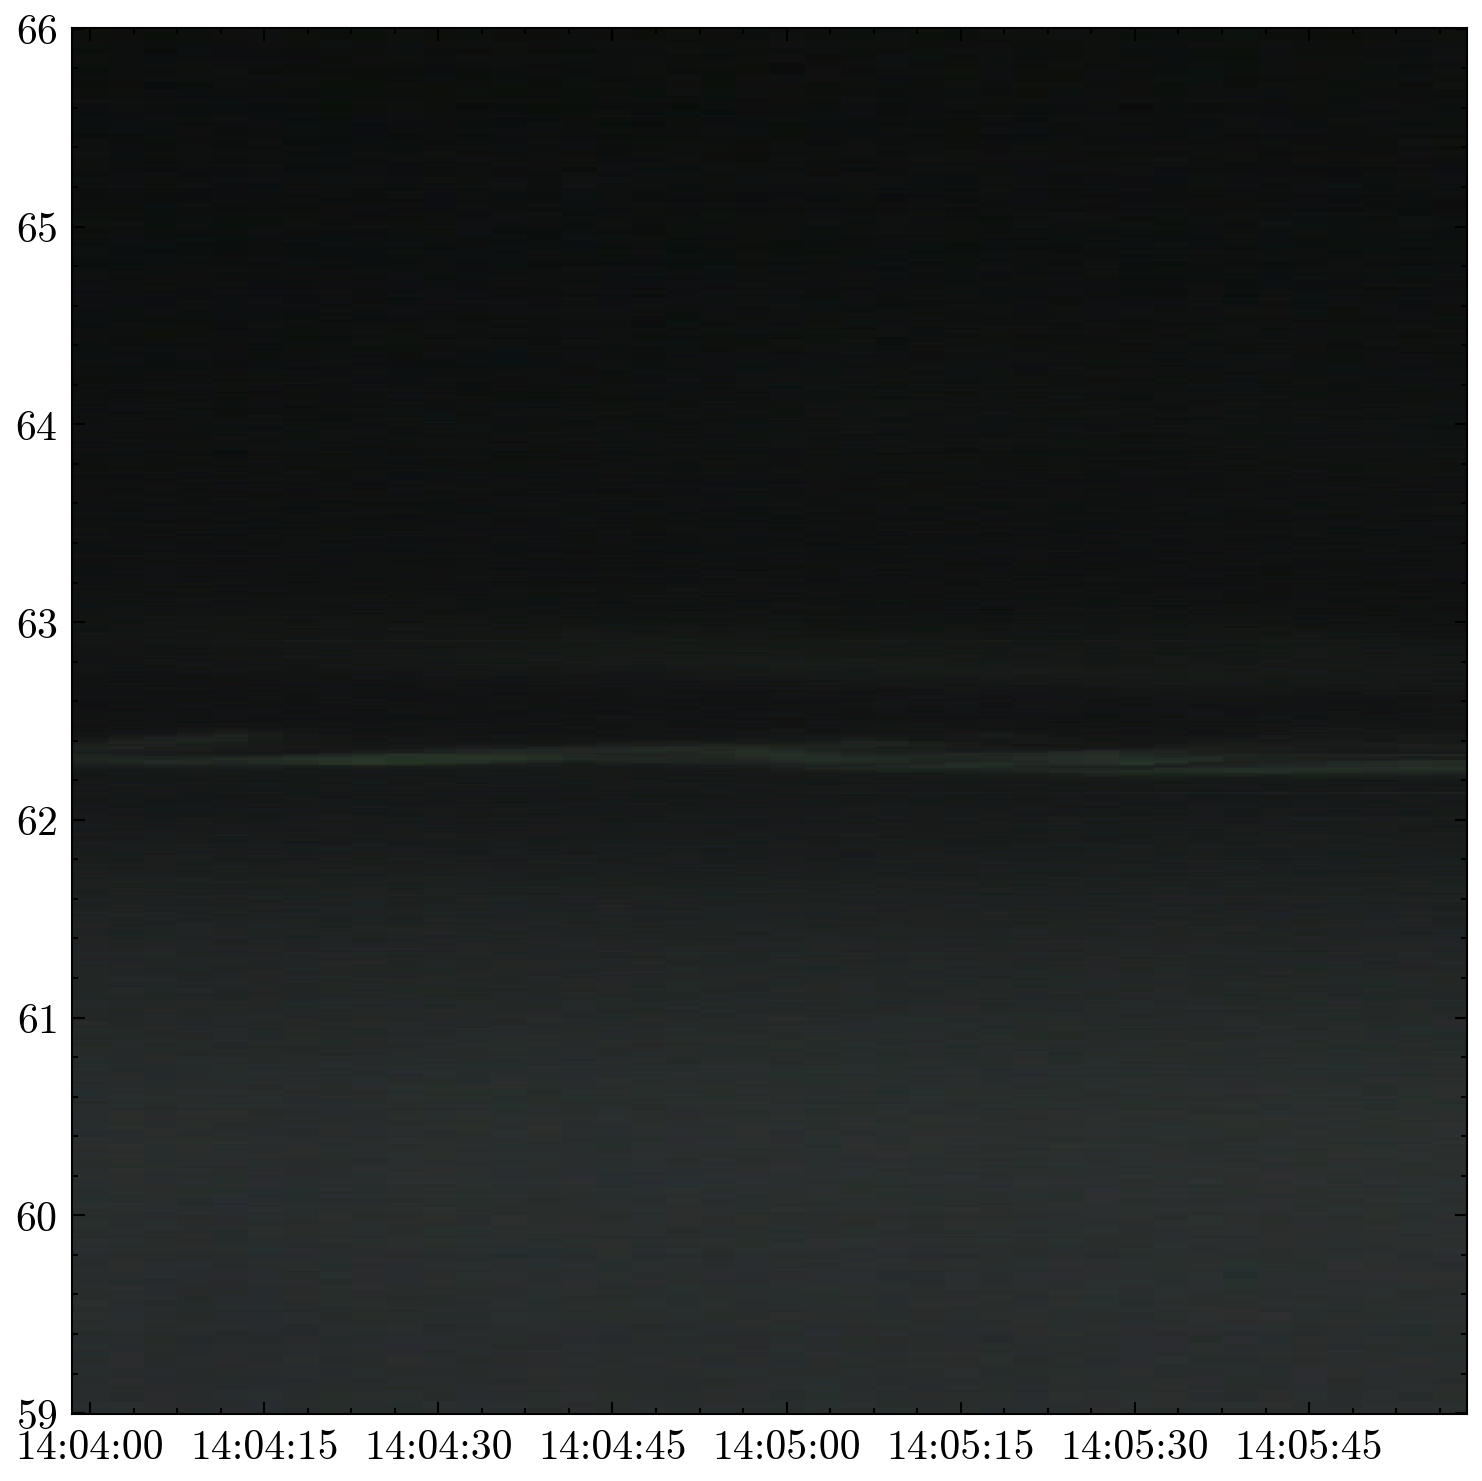

In [41]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolor( time_ewo, y_2,  np.swapaxes(pixel_closest_2, 1, 0))


TREX_RGB YKNF keogram: |################################################| 100%


(<Axes: title={'center': '2022-12-19 | TREX_RGB-YKNF keogram'}>,
 <matplotlib.collections.QuadMesh at 0x24a1a216dd0>)

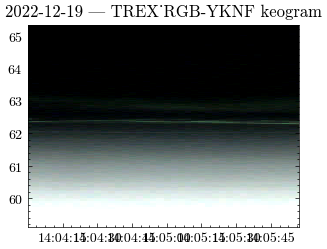

In [42]:
asi.plot_keogram()

(62.0, 64.0)

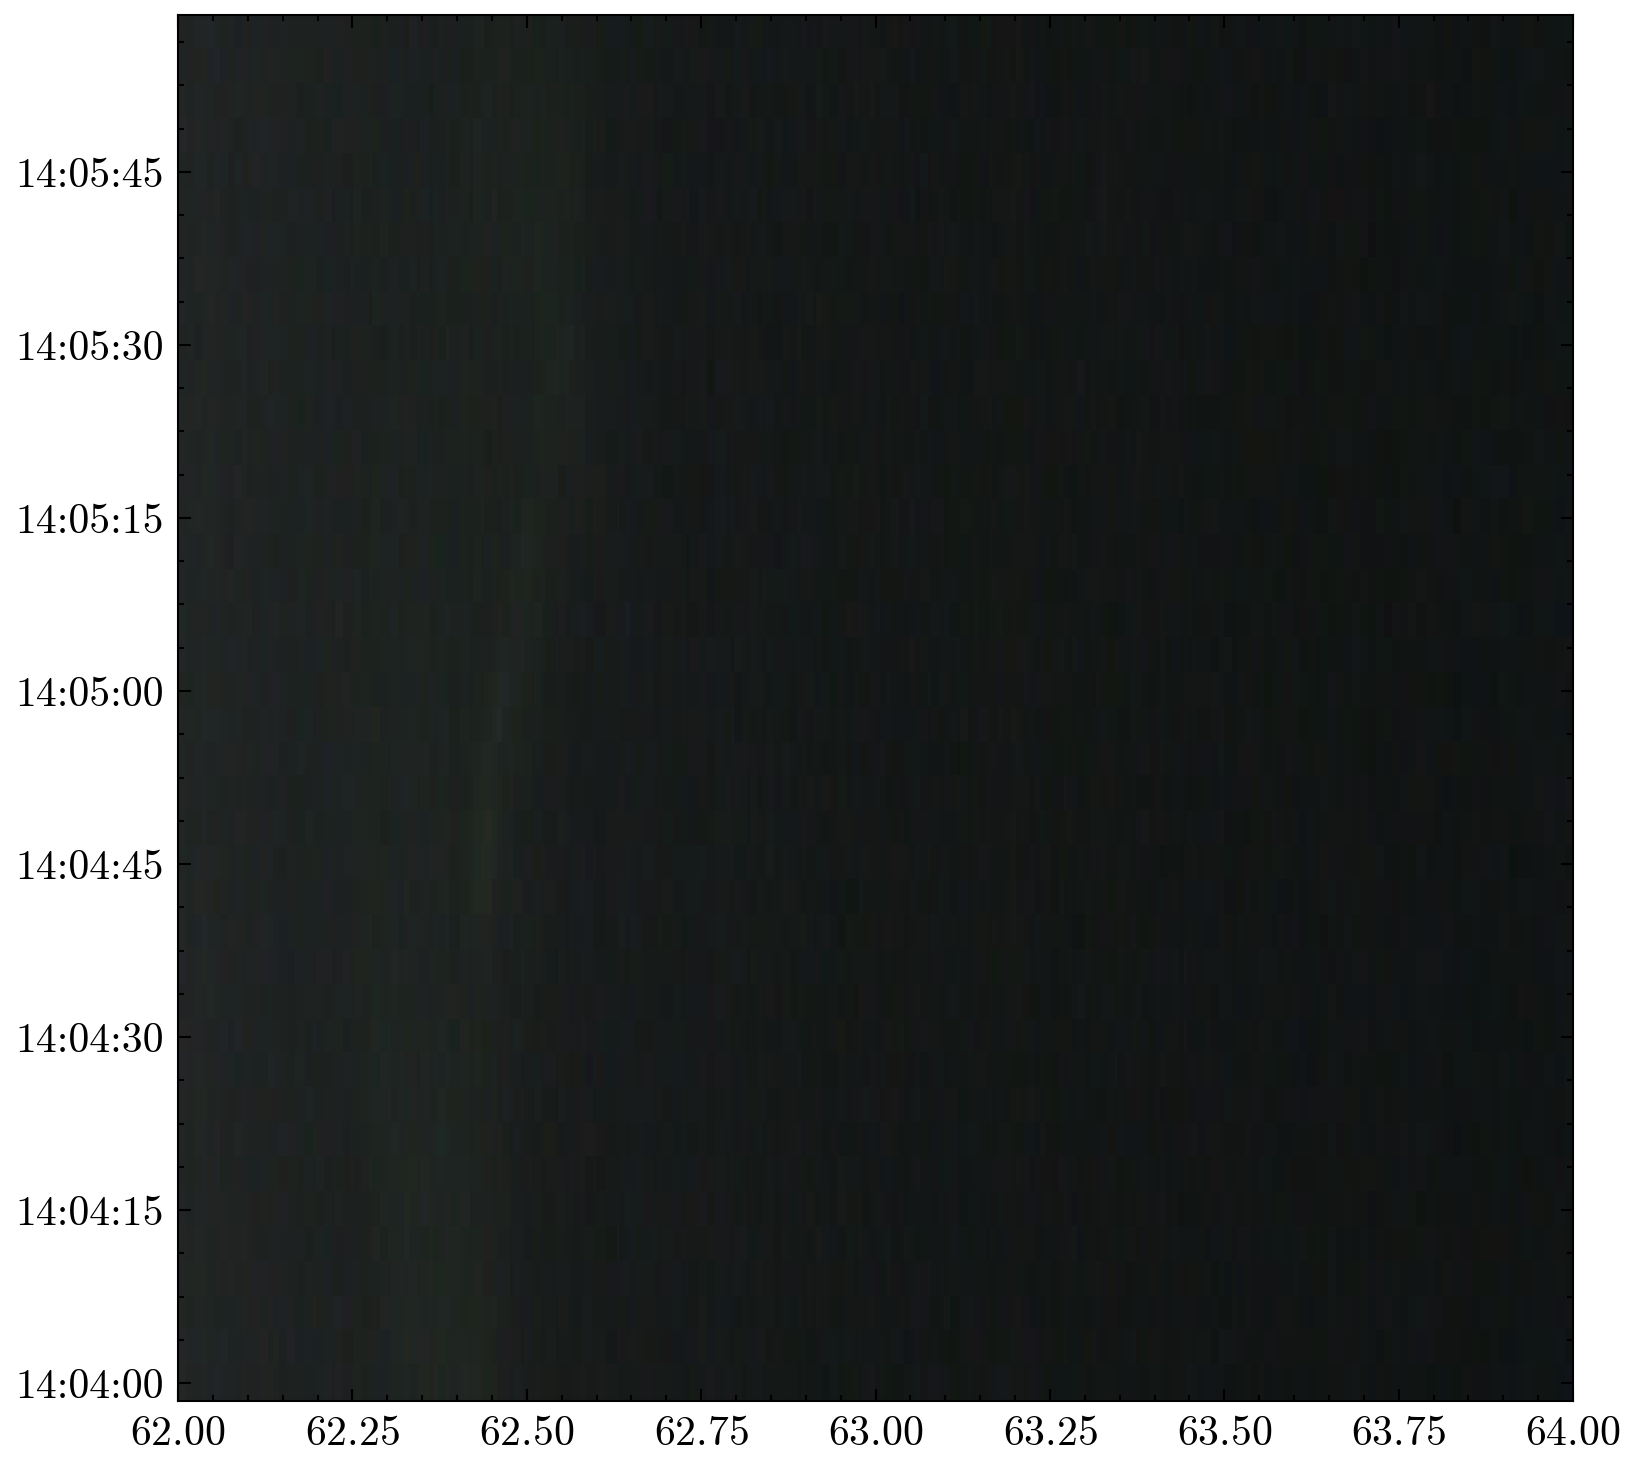

In [43]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( sat_lla_E[0], time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
plt.xlim(62,64)

(40,)


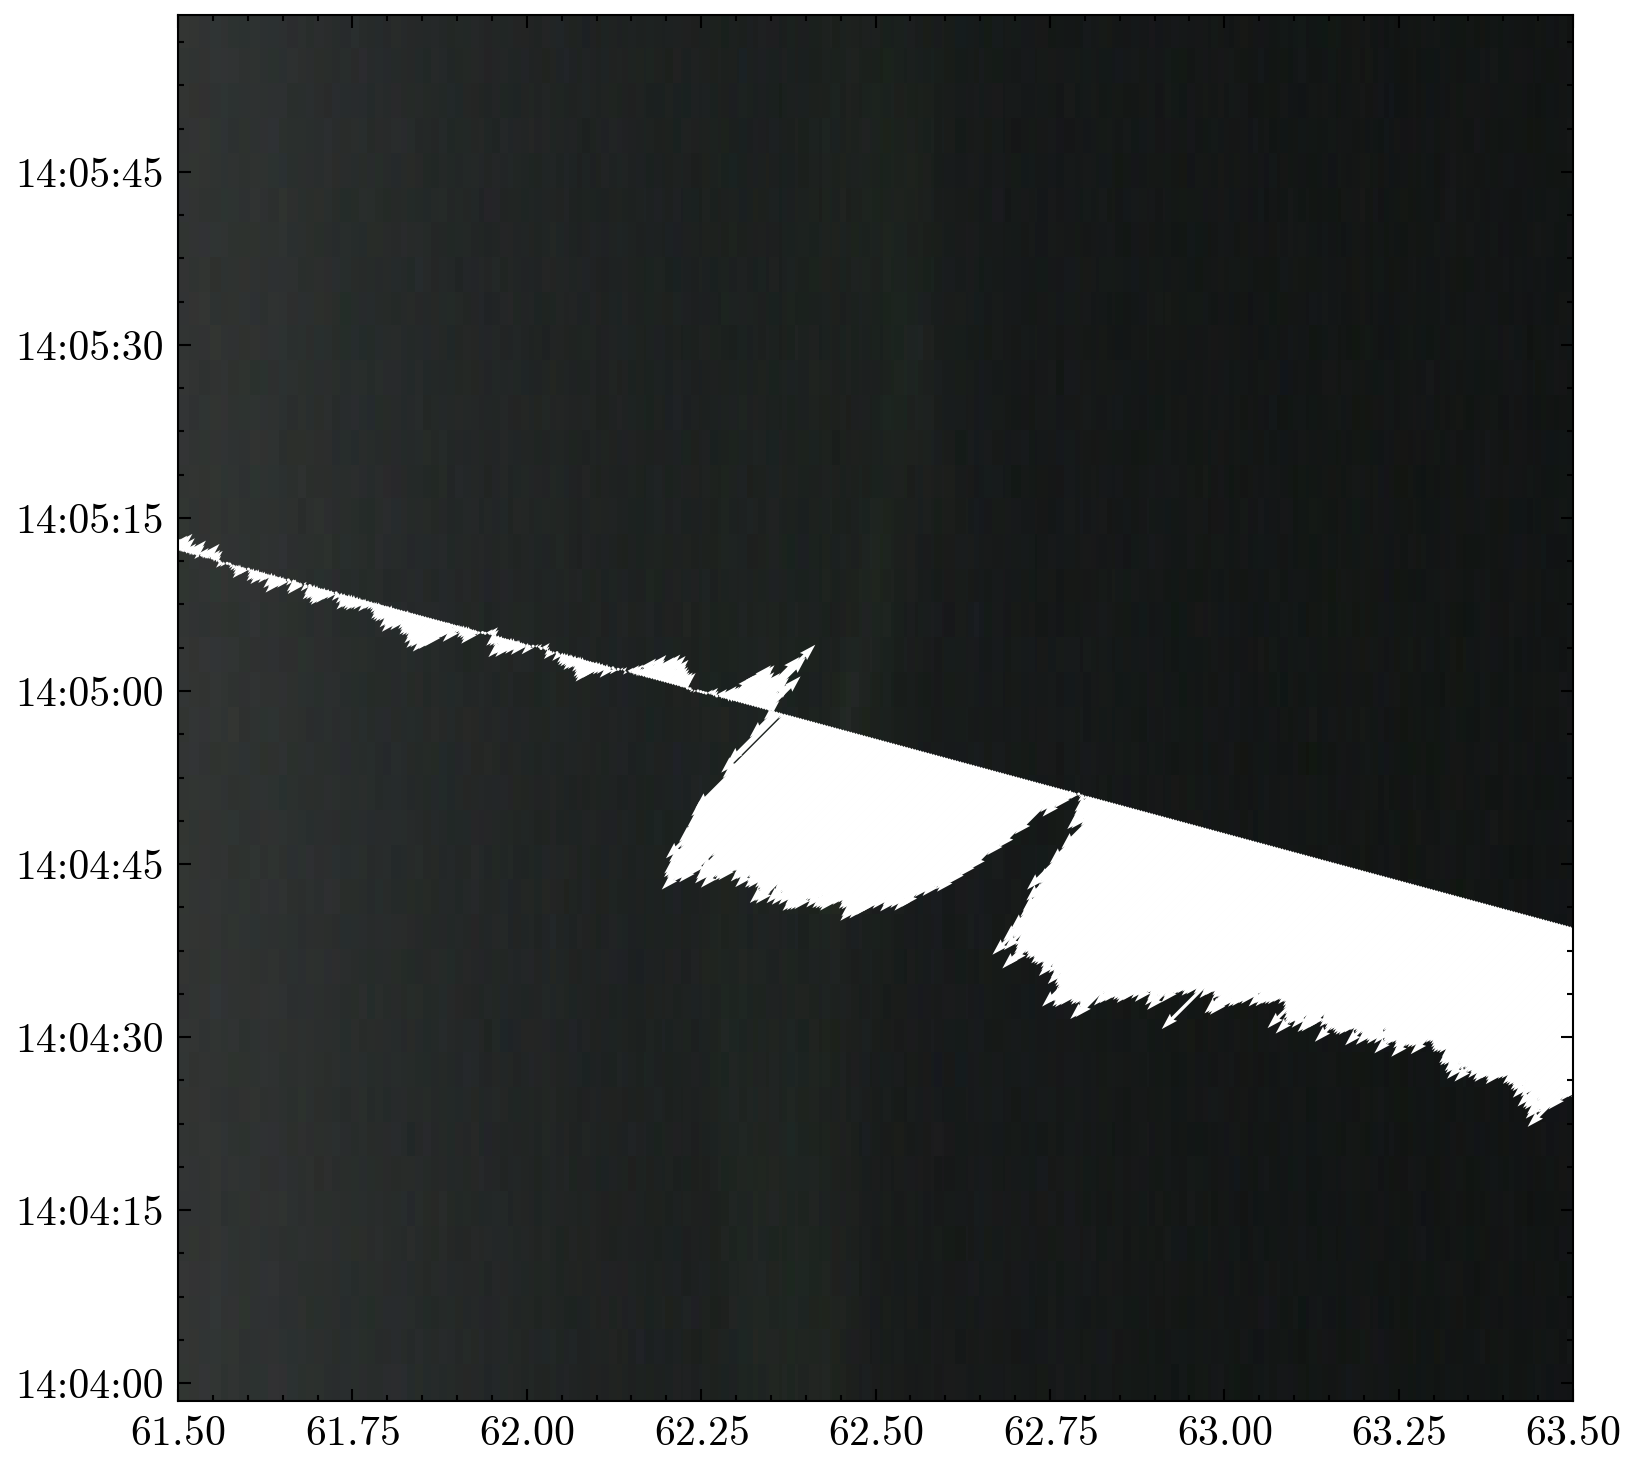

In [92]:
print(np.shape(time_ewo))
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
plt.pcolormesh( sat_lla_E[0], time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
plt.xlim(61.5,63.5)


from scipy.interpolate import CubicSpline
cs = CubicSpline(Btime, sat_lla_B[0])
latitudes_16sps = cs(Etime)
cs = CubicSpline(Btime, BNEC[:,0])
Bs_16sps = cs(Etime)

#plt.quiver(Etime,sat_lla_E[0], -Bs_16sps/np.max(np.abs(Bs_16sps)) , -Bs_16sps/np.max(np.abs(Bs_16sps)) , color='red', scale=1.2, scale_units='inches')

plt.quiver( sat_lla_E[0],Etime, ENEC[:,0]/np.max(np.abs(ENEC[:,0])), ENEC[:,0]/np.max(np.abs(ENEC[:,0])), color='white', scale=1, scale_units='inches')



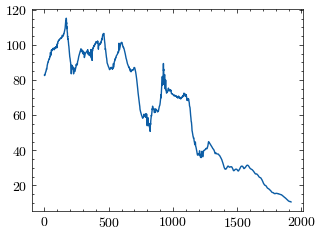

In [93]:
plt.plot( Bs_16sps)

[463 463 463 ...   0   0   0]
40
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800


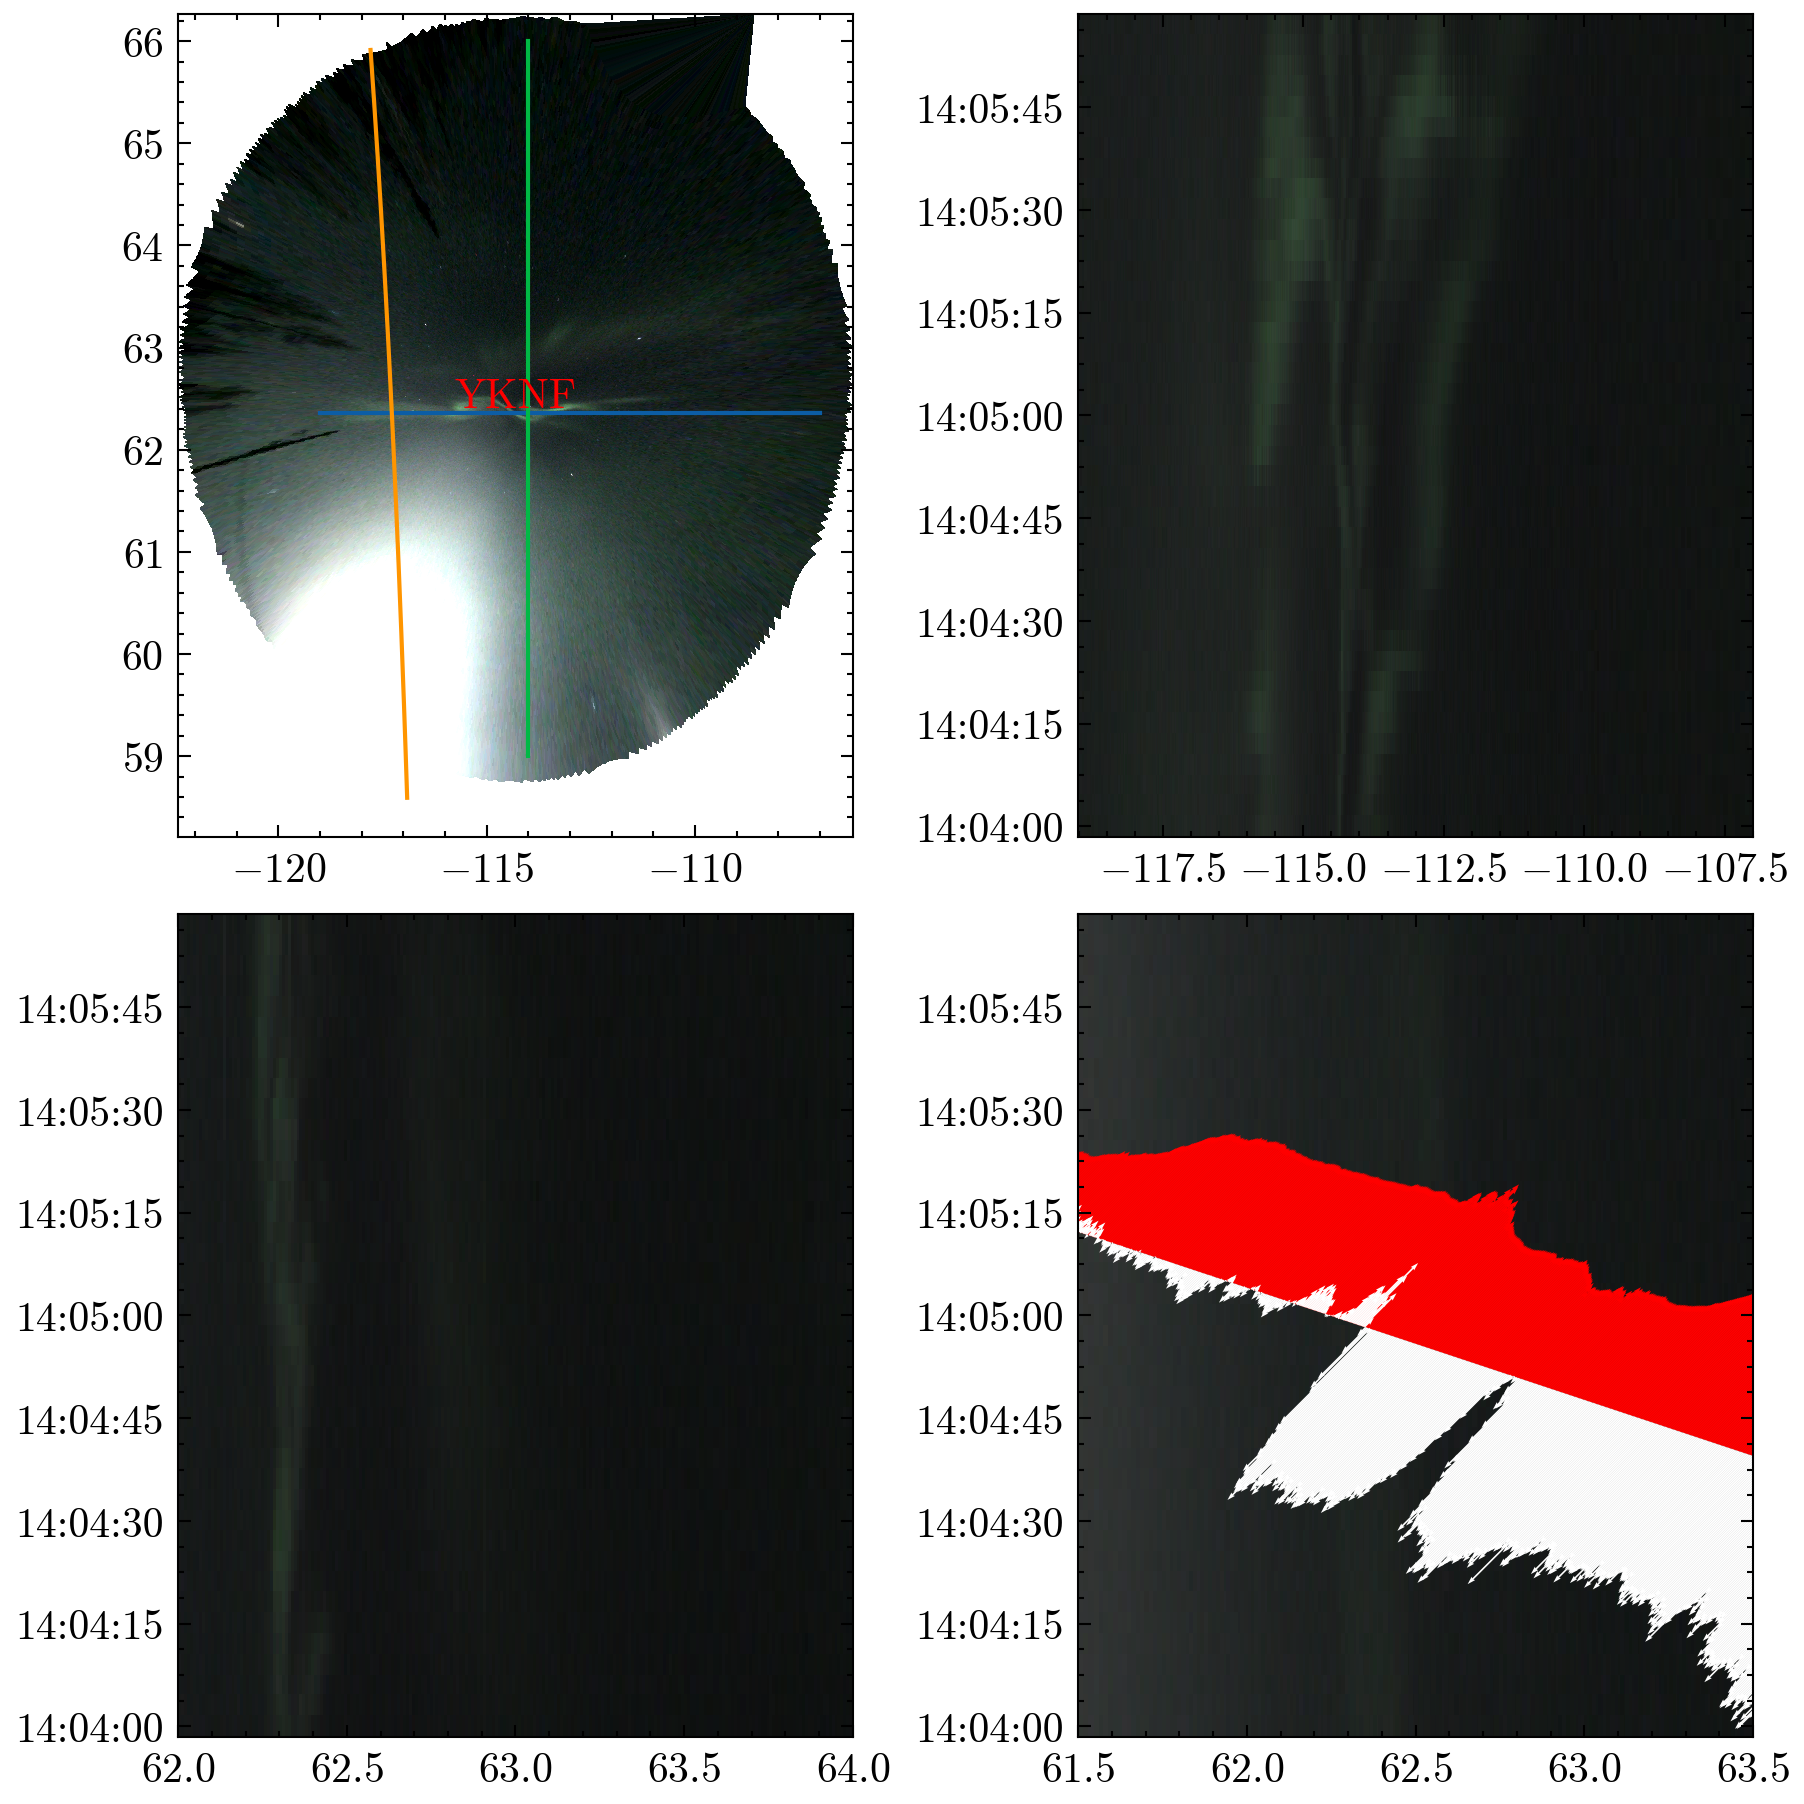

In [94]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300, nrows=2, ncols=2, constrained_layout=True) #show image of the track, and ewograms, then show the keograms of each line
axes, im_good = asi_single.plot_map(ax=ax[0][0])
print(closest_indices[:][1])



axes.plot(x_1,y_1)

axes.plot(x_2,y_2)
axes.plot(sat_lla_E[1], sat_lla_E[0]) #Ma
print(len(pixel_closest_1))

for i in range(len(pixel_closest_1)):
    print(len(pixel_closest_1[i]))


ax[0][1].pcolormesh(x_1, time_ewo,  np.reshape(pixel_closest_1, (40,800,3) ))

ax[1][0].pcolormesh(y_2, time_ewo,  np.reshape(pixel_closest_2, (40,800,3) ))
ax[1][0].set_xlim(62,64)

ax[1][1].pcolormesh( sat_lla_E[0],time_ewo,  np.reshape(pixel_closest_sat_track, (40,1920,3) ))
ax[1][1].set_xlim(61.5,63.5)

ax[1][1].quiver(sat_lla_E[0], Etime, Bs_16sps/np.max(np.abs(Bs_16sps)) , Bs_16sps/np.max(np.abs(Bs_16sps)) , color='red', scale=1.6, scale_units='inches')

ax[1][1].quiver(sat_lla_E[0], Etime, ENEC[:,0]/np.max(np.abs(ENEC[:,0])), ENEC[:,0]/np.max(np.abs(ENEC[:,0])), color='white', scale=1, scale_units='inches')


[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 18, 18, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 17, 17, 17, 17, 17, 18, 18, 18

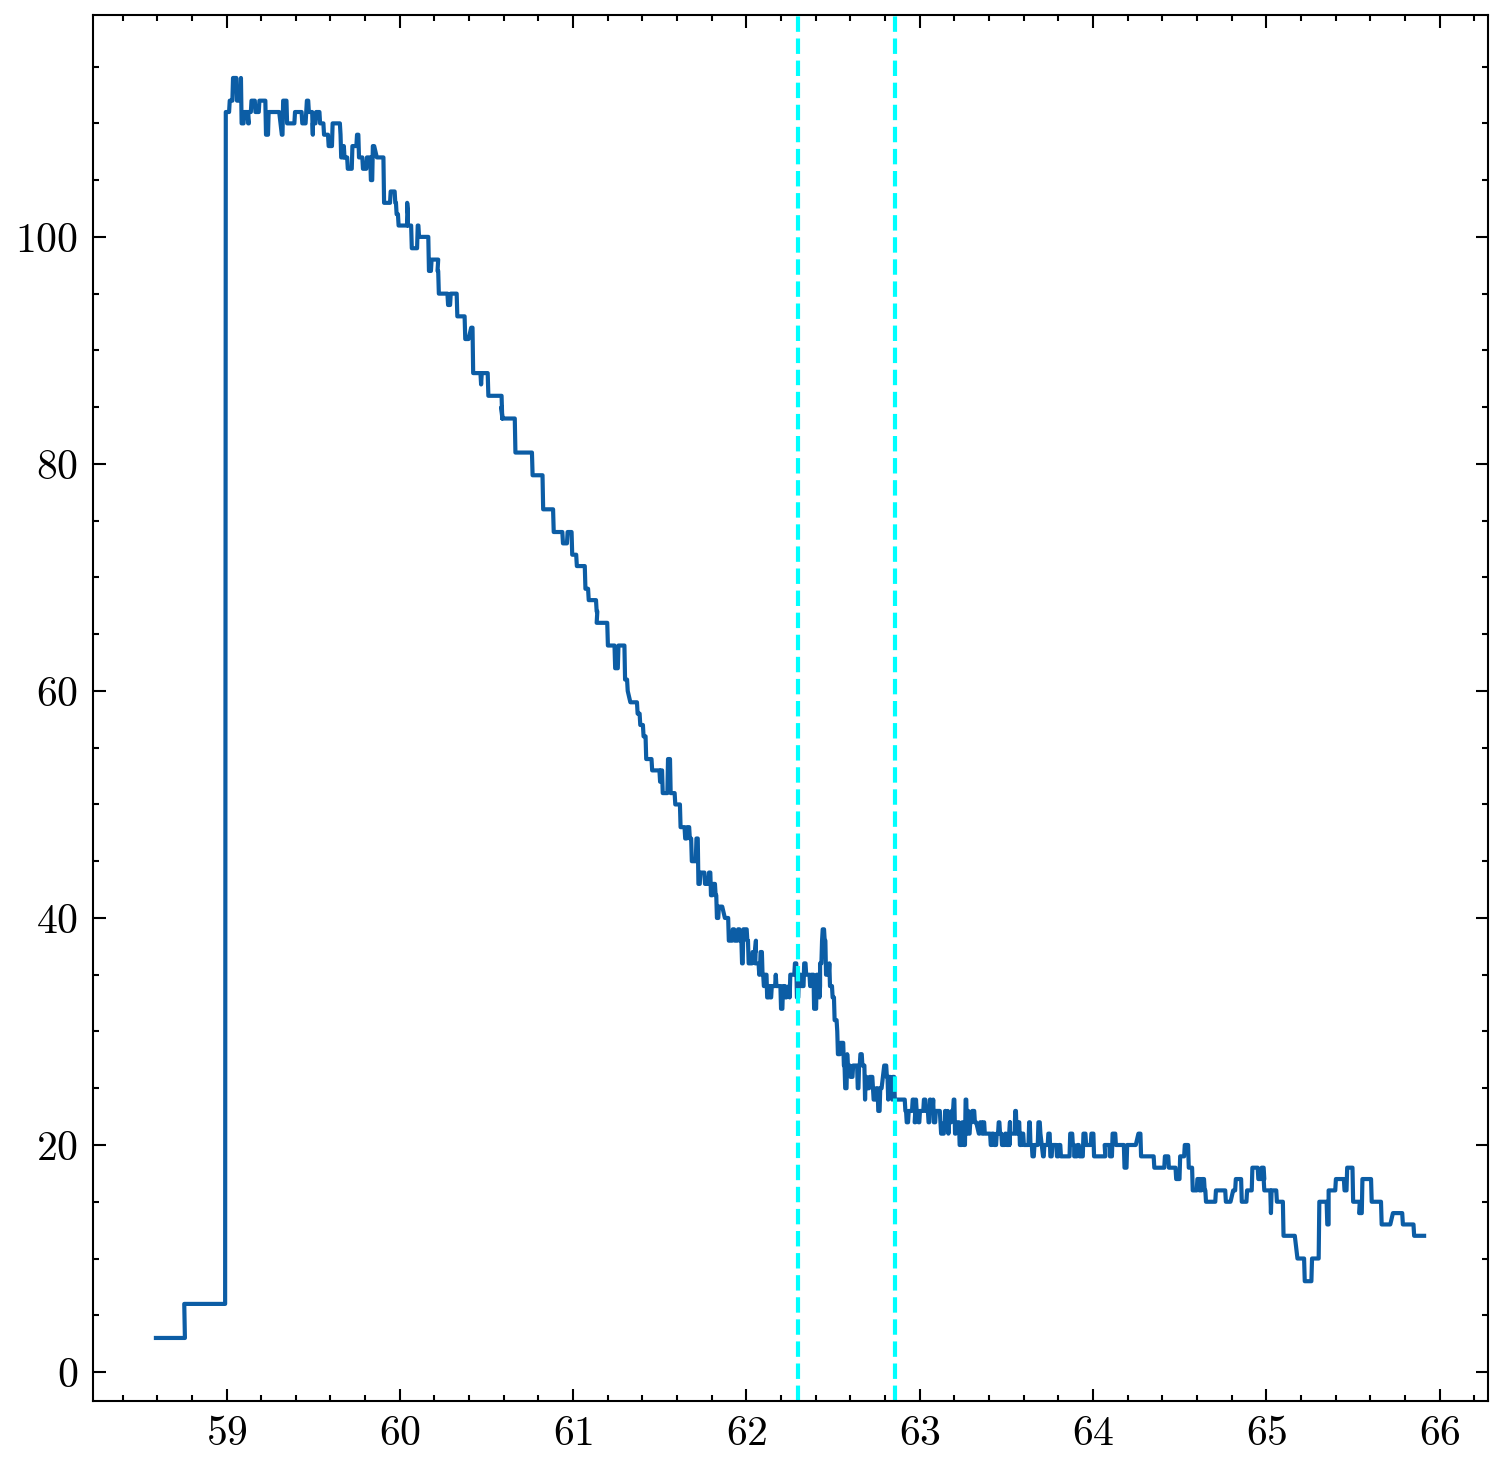

In [95]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
pixel_chosen_array= pixel_closest_sat
print(pixel_chosen_array)
plt.plot(lats, pixel_chosen_array)
plt.axvline(62.86, color='cyan', linestyle='dashed')
plt.axvline(62.3, color='cyan', linestyle='dashed')

Now lets make an ewogram

In [96]:
lat16 = sat_lla_E[0]
lat50 = sat_lla_B[0]

We want our plots to have lat verus data


(40, 3)



C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\265096416.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(61.0, 63.0)

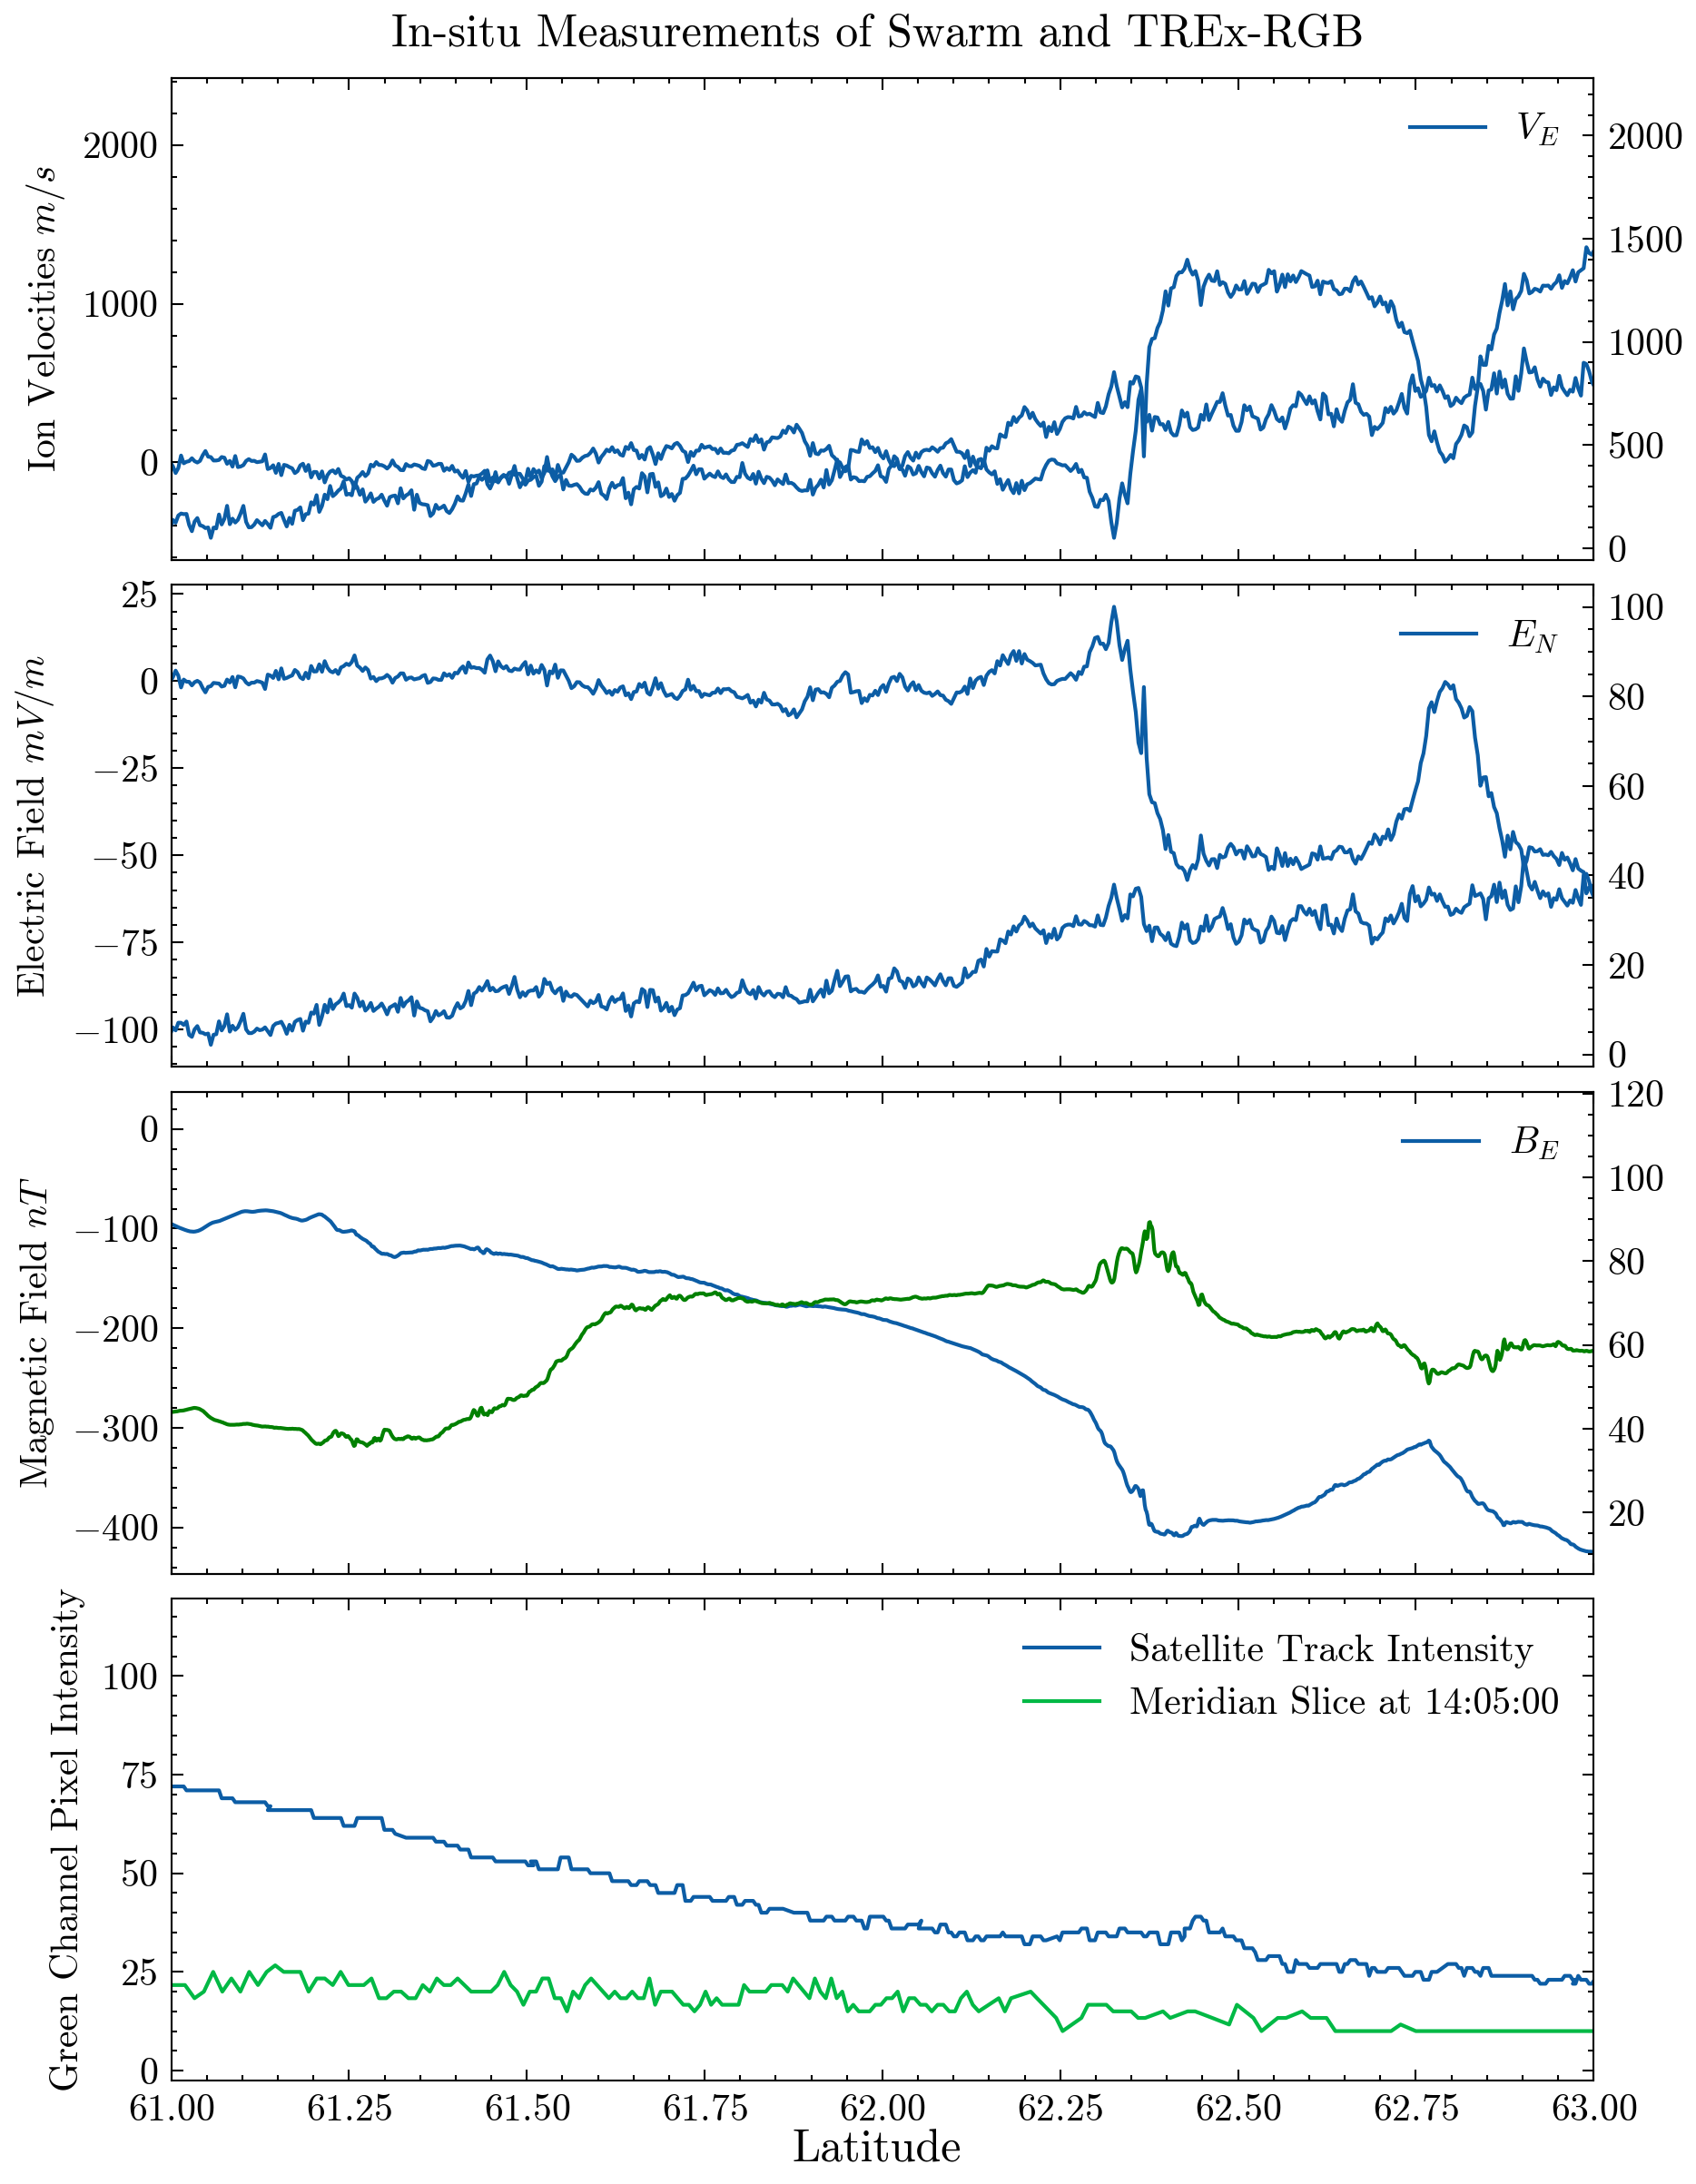

In [105]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")
Vtwin=axes[0].twinx()
Vtwin.plot(lat16,VNEC[:,0], label=r"$V_{N}$")

axes[1].plot(lat16, ENEC[:,0], label=r"$E_{N}$")
Etwin=axes[1].twinx()

Etwin.plot(lat16,ENEC[:,1], label=r"$E_{E}$")



Btwin=axes[2].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='green')
axes[2].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
print()
axes[3].plot(im_good.get_coordinates()[:, 60, 1][:-1], im_good.get_array()[:, 60, 0]*100+10, label="Meridian Slice at 14:05:00") #change colors



plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(61, 63)
axes[1].set_xlim(61, 63)
axes[2].set_xlim(61, 63)
axes[3].set_xlim(61, 63)

Doesn't line up because the arc doesnt follow magnetic latitude, its more aligned east west due to the convection flow shape

In [106]:
import numpy as np
import datetime

# Example array of Python datetime objects
datetime_array = np.array([
    datetime.datetime(2024, 8, 10, 12, 0),
    datetime.datetime(2024, 8, 11, 12, 0),
    datetime.datetime(2024, 8, 12, 12, 0),
    datetime.datetime(2024, 8, 13, 12, 0),
    datetime.datetime(2024, 8, 14, 12, 0)
])

# Given start and end datetimes
start_datetime = datetime.datetime(2024, 8, 11, 0, 0)
end_datetime = datetime.datetime(2024, 8, 13, 0, 0)

# Find the indices where datetime_array is between start_datetime and end_datetime
indices = np.where((datetime_array >= start_datetime) & (datetime_array <= end_datetime))[0]

print(indices)

[1 2]


Now we want to do a bandpass filter for the above electrodynamics data so we can differeinate between large and small scale. We will do a variety of filters so we can choose one that looks good. We will do 0.05Hz, 0.1Hz, 0.2Hz, 0.5Hz to 6Hz

In [107]:
from scipy.signal import butter, filtfilt

def butter_bandpass(cutoffs, fs, order=4):
    if cutoffs[0] ==0:
        return butter(order, cutoffs[1], fs=fs, btype="low")
    else:
        return butter(order, cutoffs, fs=fs, btype="band")


def butter_bandpass_filter(data, cutoffs, fs, order=4):
    b, a = butter_bandpass(cutoffs, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [108]:
V005,V01,V02,V05= np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC)))
E005,E01,E02,E05 = np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC)))
B005,B01,B02,B05 = np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC)))
for i in range(3):
    V005[:, i]=butter_bandpass_filter(VNEC[:, i], [0.05, 6], 16)
    V01[:, i]=butter_bandpass_filter(VNEC[:, i], [0.1, 6], 50)
    V02[:, i]=butter_bandpass_filter(VNEC[:, i], [0.2, 6], 50)
    V05[:, i]=butter_bandpass_filter(VNEC[:, i], [0.5, 6], 50)

    E005[:, i]=butter_bandpass_filter(ENEC[:, i], [0.05, 6], 16)
    E01[:, i]=butter_bandpass_filter(ENEC[:, i], [0.1, 6], 16)
    E02[:, i]=butter_bandpass_filter(ENEC[:, i], [0.2, 6], 16)
    E05[:, i]=butter_bandpass_filter(ENEC[:, i], [0.5, 6], 16)


    B005[:, i]=butter_bandpass_filter(BNEC[:, i], [0.05, 6], 50)
    B01[:, i]=butter_bandpass_filter(BNEC[:, i], [0.1, 6], 50)
    B02[:, i]=butter_bandpass_filter(BNEC[:, i], [0.2, 6], 50)
    B05[:, i]=butter_bandpass_filter(BNEC[:, i], [0.5, 6], 50)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\517856379.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

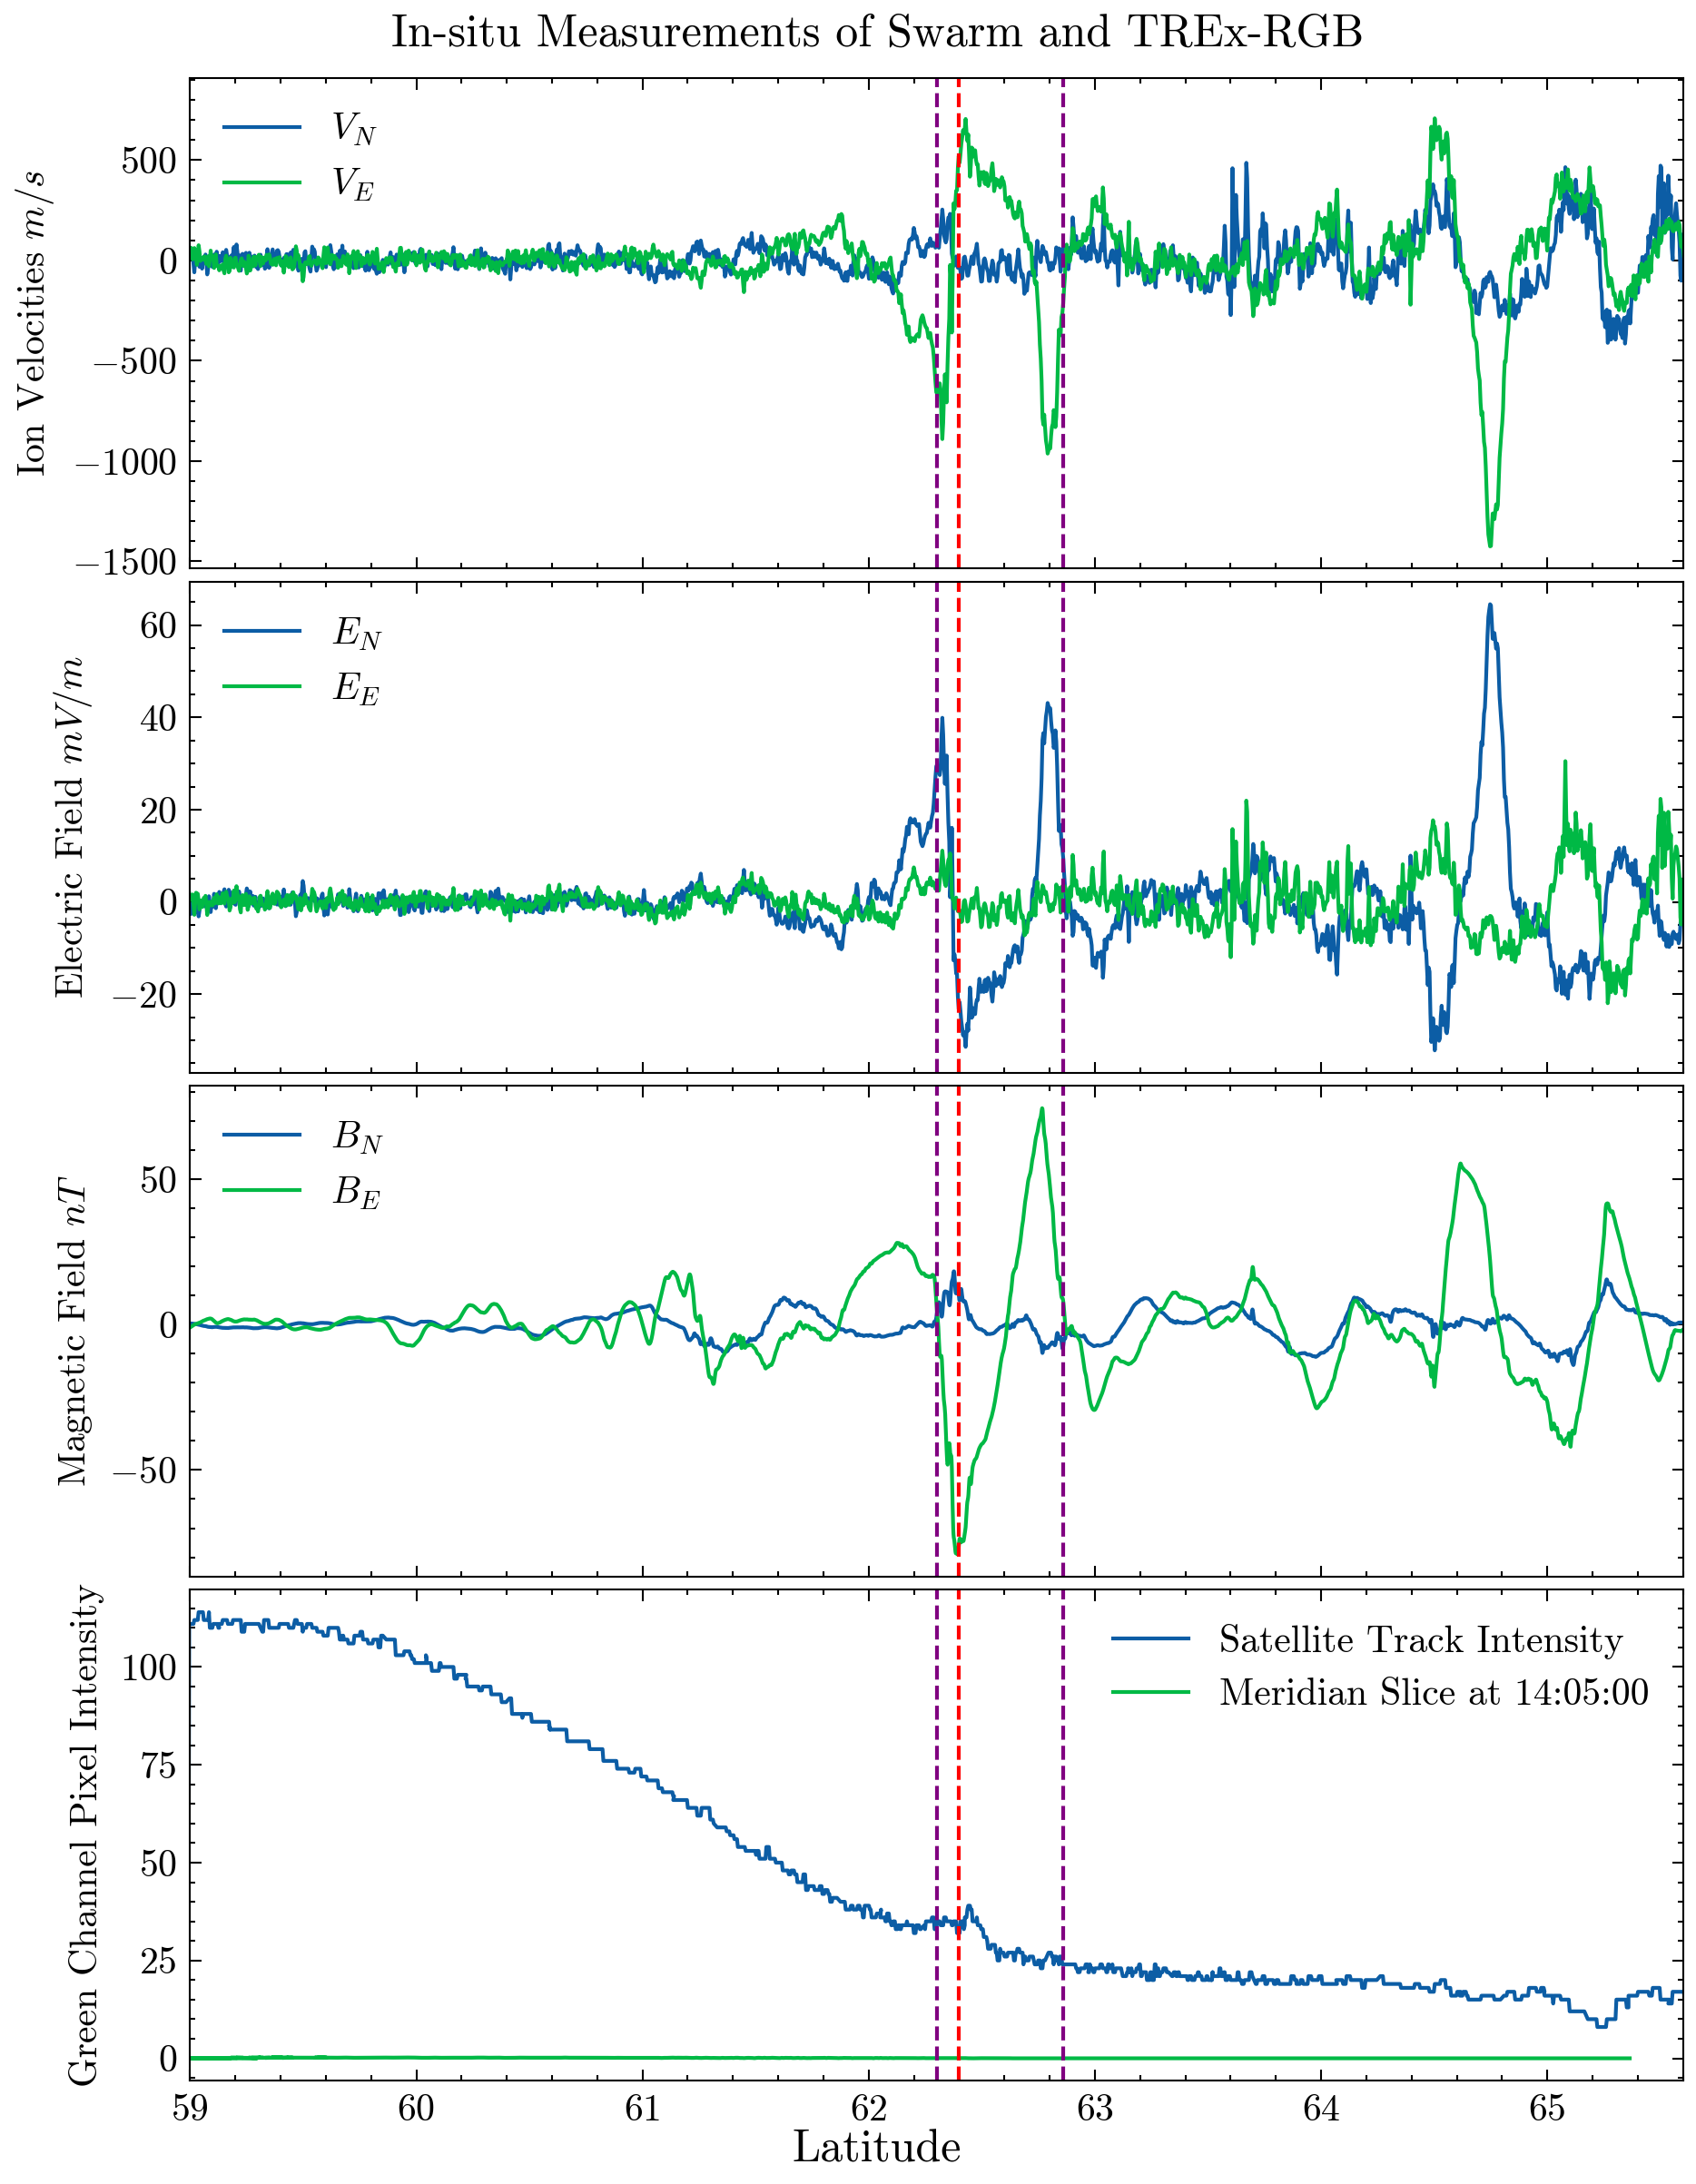

In [109]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V005[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V005[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E005[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E005[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B005[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B005[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\3546714463.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

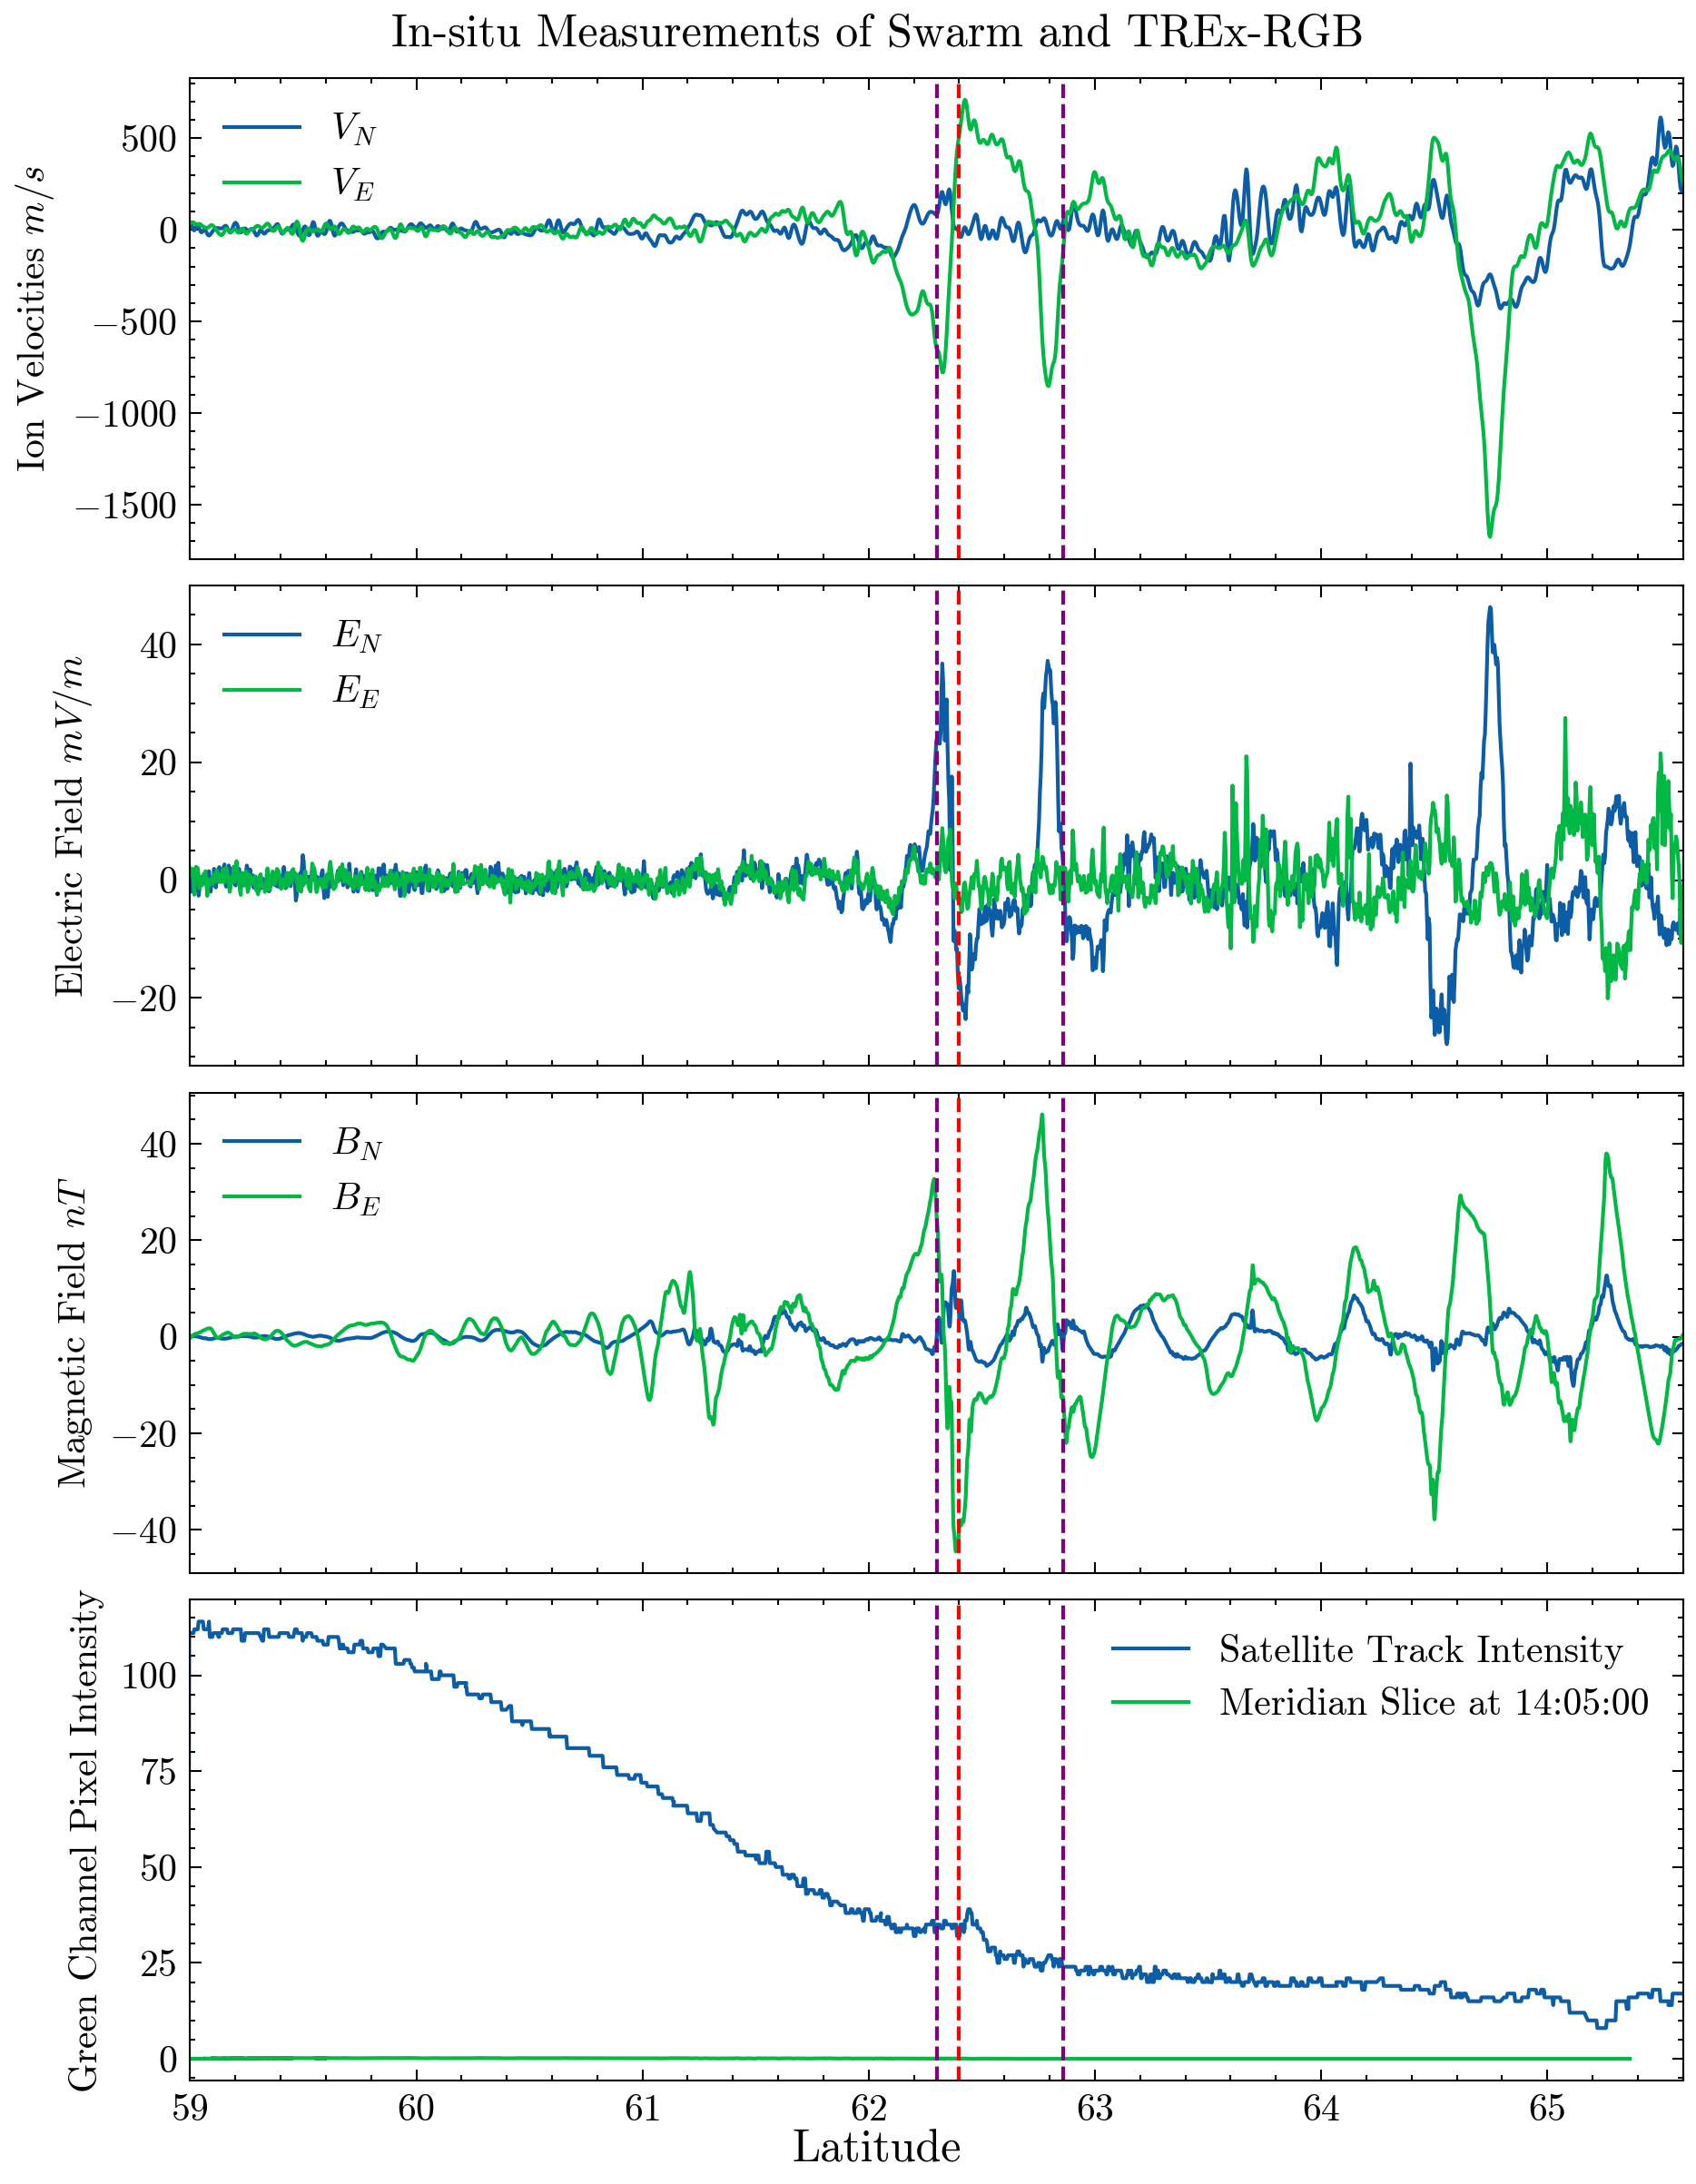

In [110]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V01[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V01[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E01[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E01[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B01[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B01[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\2505789916.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

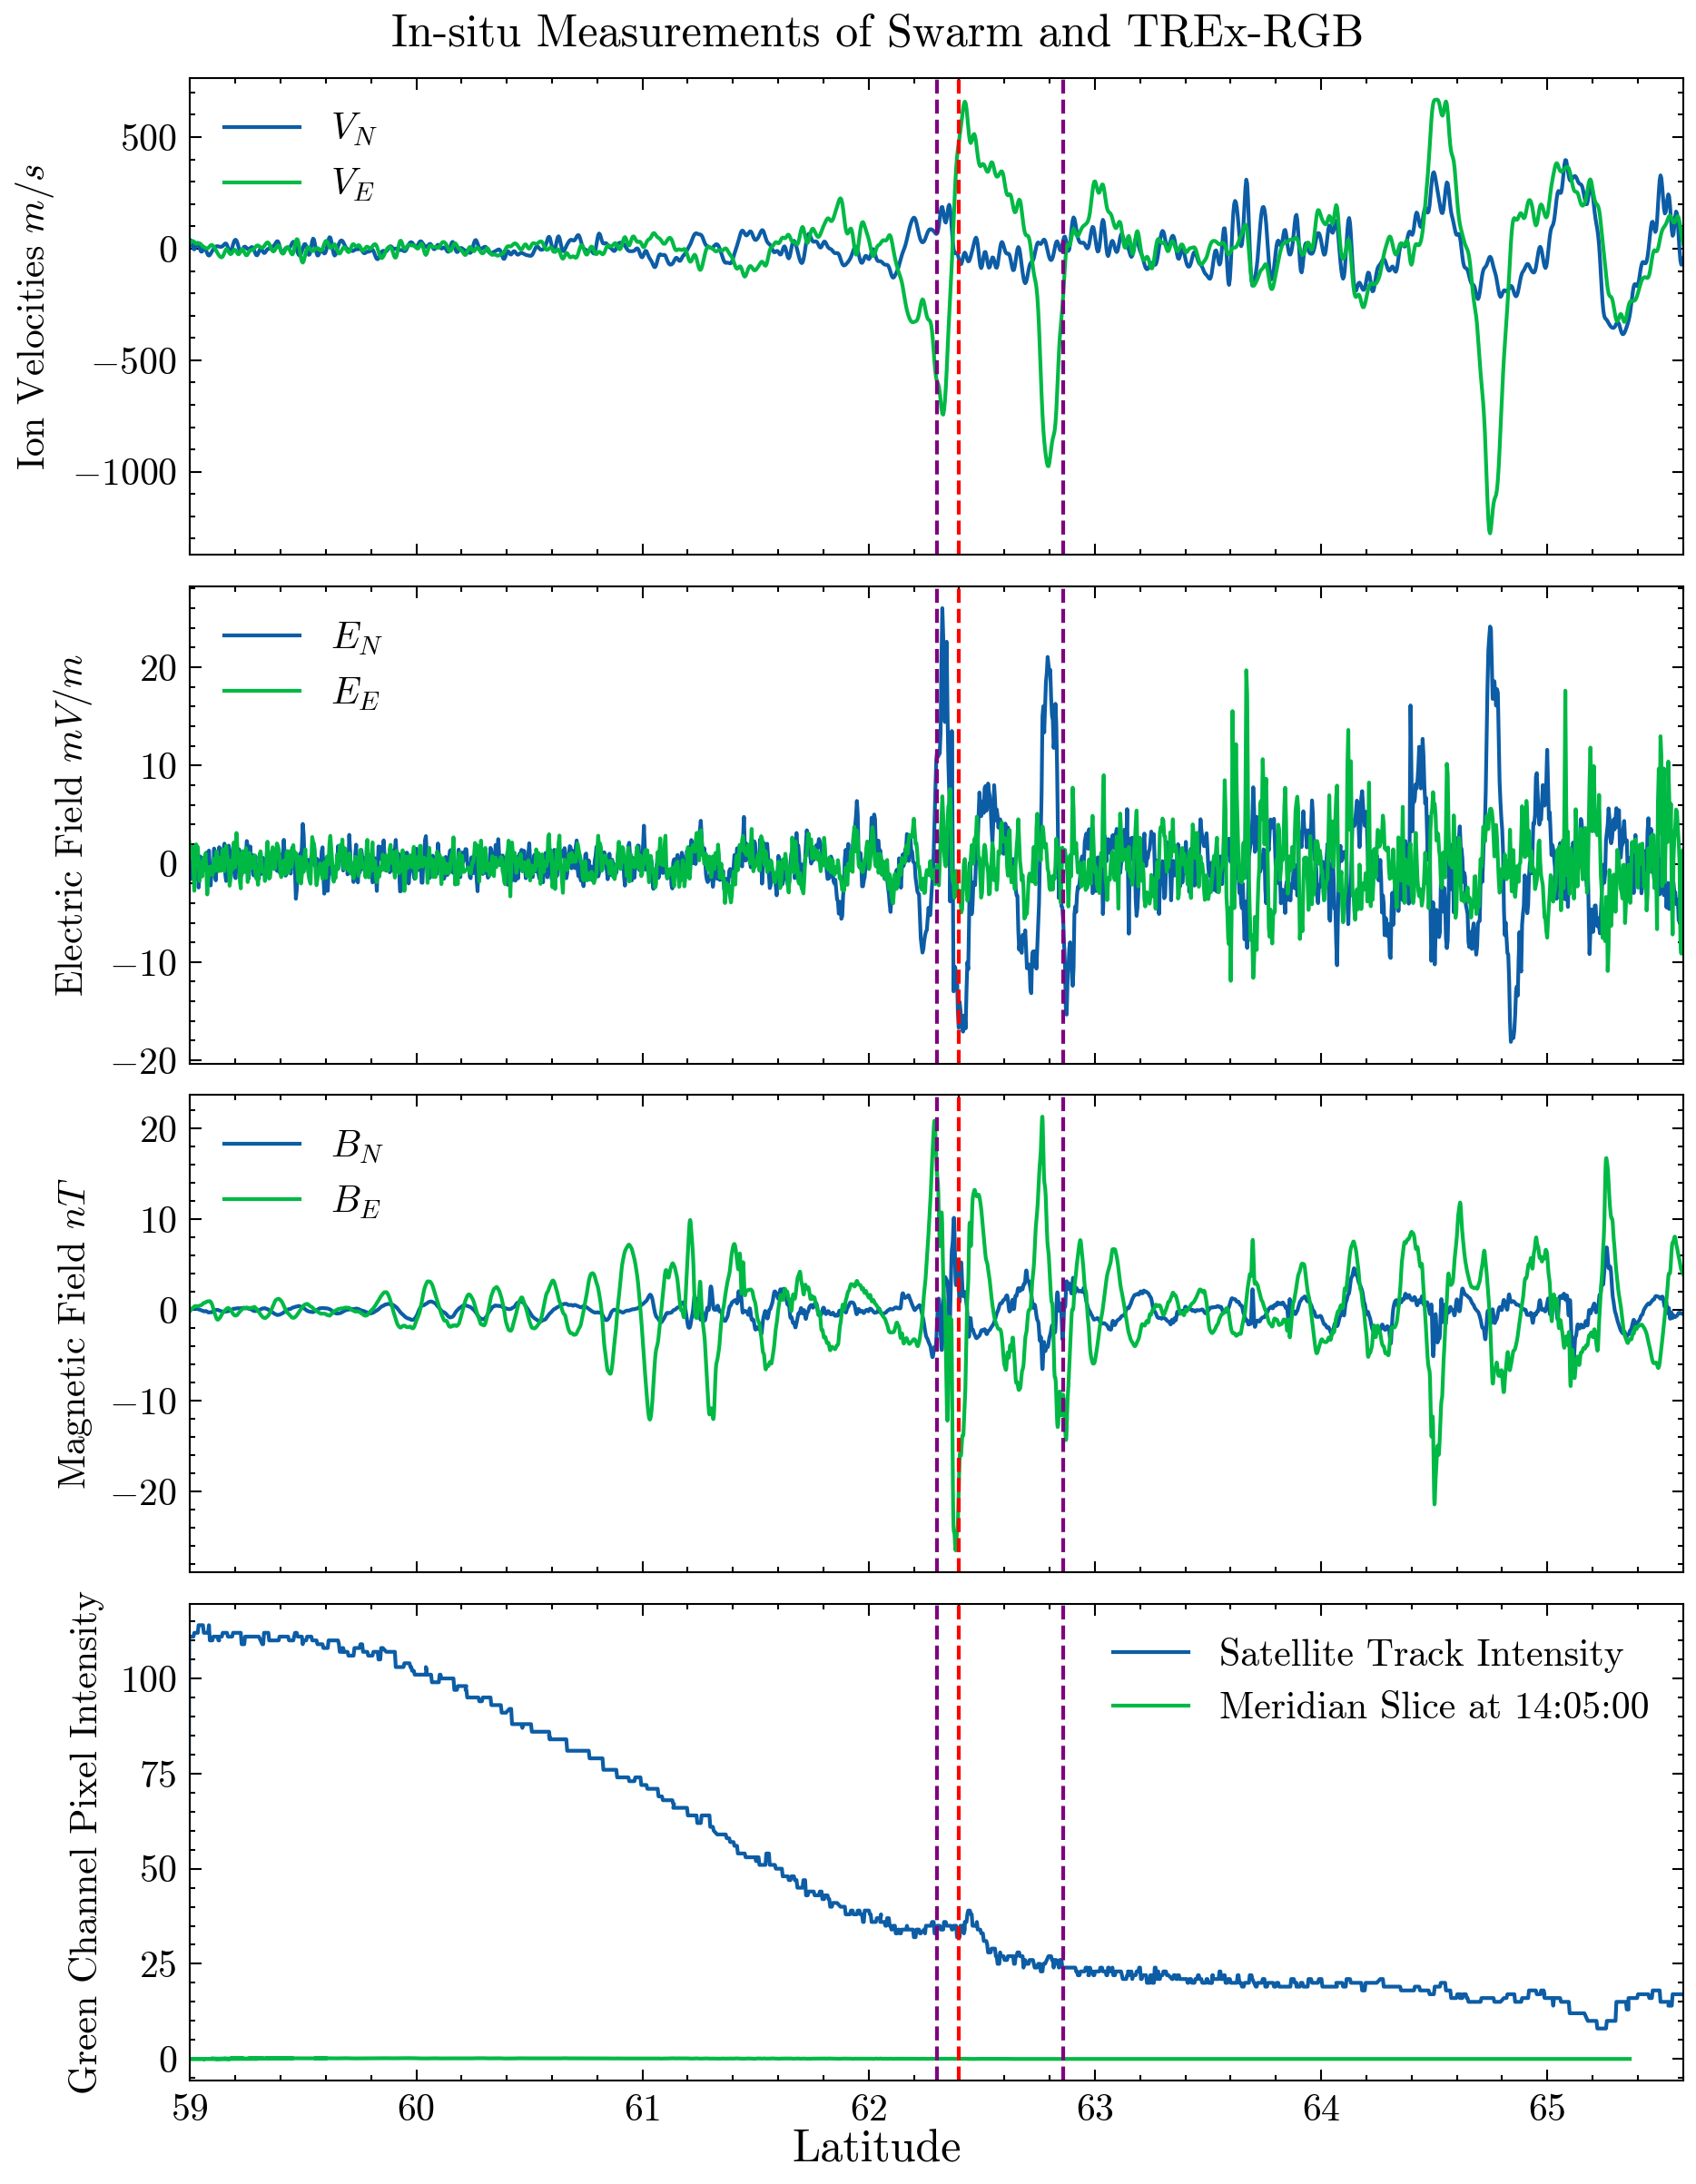

In [111]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V02[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V02[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E02[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E02[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B02[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B02[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_33252\817563030.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

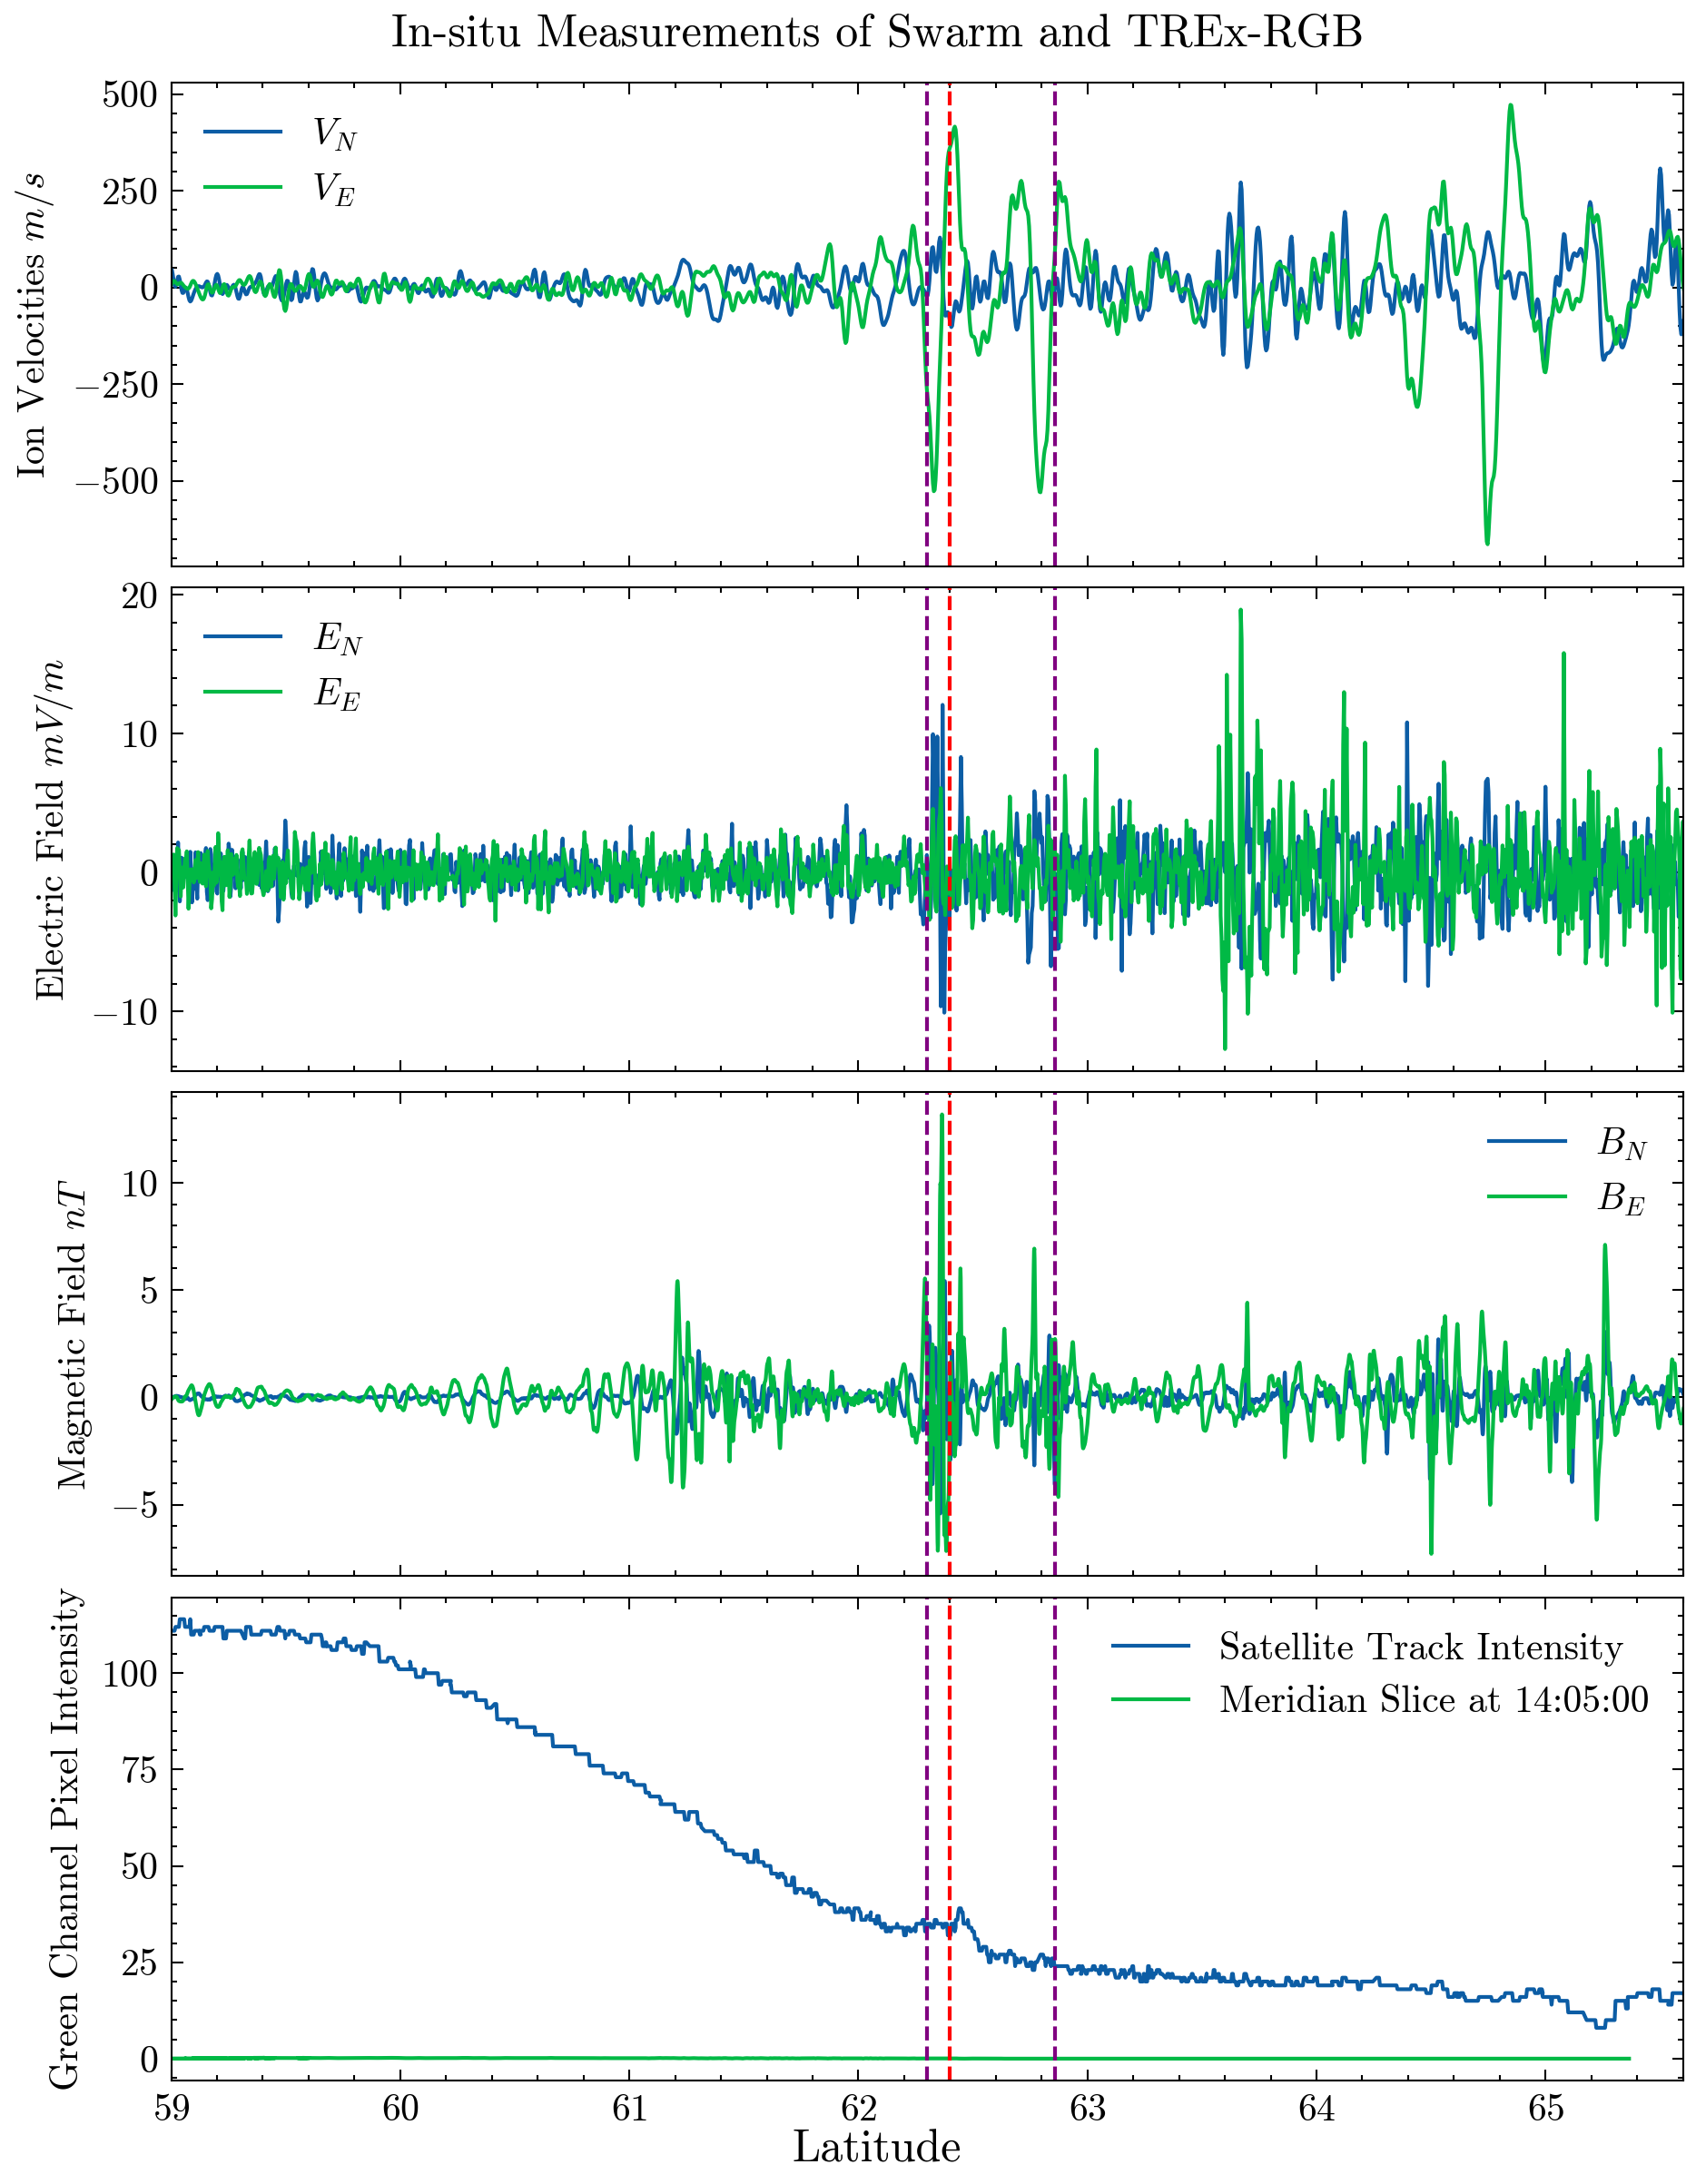

In [112]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V05[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V05[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E05[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E05[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B05[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B05[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)